In [151]:
import sys, os, platform, glob, zipfile, math, shutil, random, gc, json, re, pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Quiet installs if missing
try:
    import seaborn as sns
except Exception:
    !pip -q install seaborn
    import seaborn as sns

try:
    import sklearn
except Exception:
    !pip -q install -U scikit-learn
    import sklearn

try:
    import tensorflow as tf
except Exception:
    !pip -q install -U tensorflow
    import tensorflow as tf

print("Python:", sys.version)
print("Platform:", platform.platform())
print("TensorFlow:", tf.__version__)
print("GPU available:", len(tf.config.list_physical_devices('GPU')) > 0)

Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Platform: Linux-6.6.105+-x86_64-with-glibc2.35
TensorFlow: 2.19.0
GPU available: False


In [152]:
df1 = pd.read_csv('muontracks1.csv')

iD = df1['collisionID'].to_numpy()
trackID = df1['trackID'].to_numpy()
mcID = df1['mcID'].to_numpy()
eta = df1['eta'].to_numpy()
pt = df1['pt'].to_numpy()
p = df1['p'].to_numpy()
phi = df1['phi'].to_numpy()
motherPDG = df1['motherPDG'].to_numpy()
nClusters = df1['nClusters'].to_numpy()
trackType = df1['trackType'].to_numpy()
pDca = df1['pDca'].to_numpy()
chi2 = df1['chi2'].to_numpy()
chi2MatchMCHMID = df1['chi2MatchMCHMID'].to_numpy()


In [153]:
df1.head(8)


,collisionID,trackID,mcID,eta,pt,p,phi,motherPDG,nClusters,trackType,pDca,chi2,chi2MatchMCHMID,isPrompt
0,111,0,88367,-3.16496,0.243115,2.884550,-2.590800,211,11,3,76.7159,0.515625,1.218750,1
1,111,1,88367,2.72339,0.115458,0.883115,6.495230,211,11,0,76.7159,370688.000000,1.218750,1
2,125,2,102667,-3.41393,0.858880,13.062400,2.801200,321,12,3,44.9307,0.144531,0.554688,1
3,125,3,102667,-3.43907,0.996715,15.543900,2.779760,321,12,0,44.9307,37.000000,0.554688,1
4,168,4,133004,-2.81062,0.592036,4.937700,-2.291630,211,10,2,58.2282,1000.000000,-1.000000,1
5,168,5,133004,-2.35260,0.211855,1.123670,-2.230570,211,10,4,58.2282,0.578125,-1.000000,1
6,218,6,171002,-2.93607,0.560673,5.296890,1.075610,321,10,3,140.5290,0.210938,1.062500,1
7,218,7,171002,-3.42954,0.515674,7.965860,0.911866,321,10,0,140.5290,69.000000,1.062500,1


In [154]:
#len(df1)
df1.shape

(63807, 14)

In [155]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63807 entries, 0 to 63806
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   collisionID      63807 non-null  int64  
 1   trackID          63807 non-null  int64  
 2   mcID             63807 non-null  int64  
 3   eta              63778 non-null  float64
 4   pt               63807 non-null  float64
 5   p                63807 non-null  float64
 6   phi              63807 non-null  float64
 7   motherPDG        63807 non-null  int64  
 8   nClusters        63807 non-null  int64  
 9   trackType        63807 non-null  int64  
 10  pDca             63807 non-null  float64
 11  chi2             63807 non-null  float64
 12  chi2MatchMCHMID  63807 non-null  float64
 13  isPrompt         63807 non-null  int64  
dtypes: float64(7), int64(7)
memory usage: 6.8 MB


In [156]:
sns.set_theme(style="whitegrid", palette="icefire")


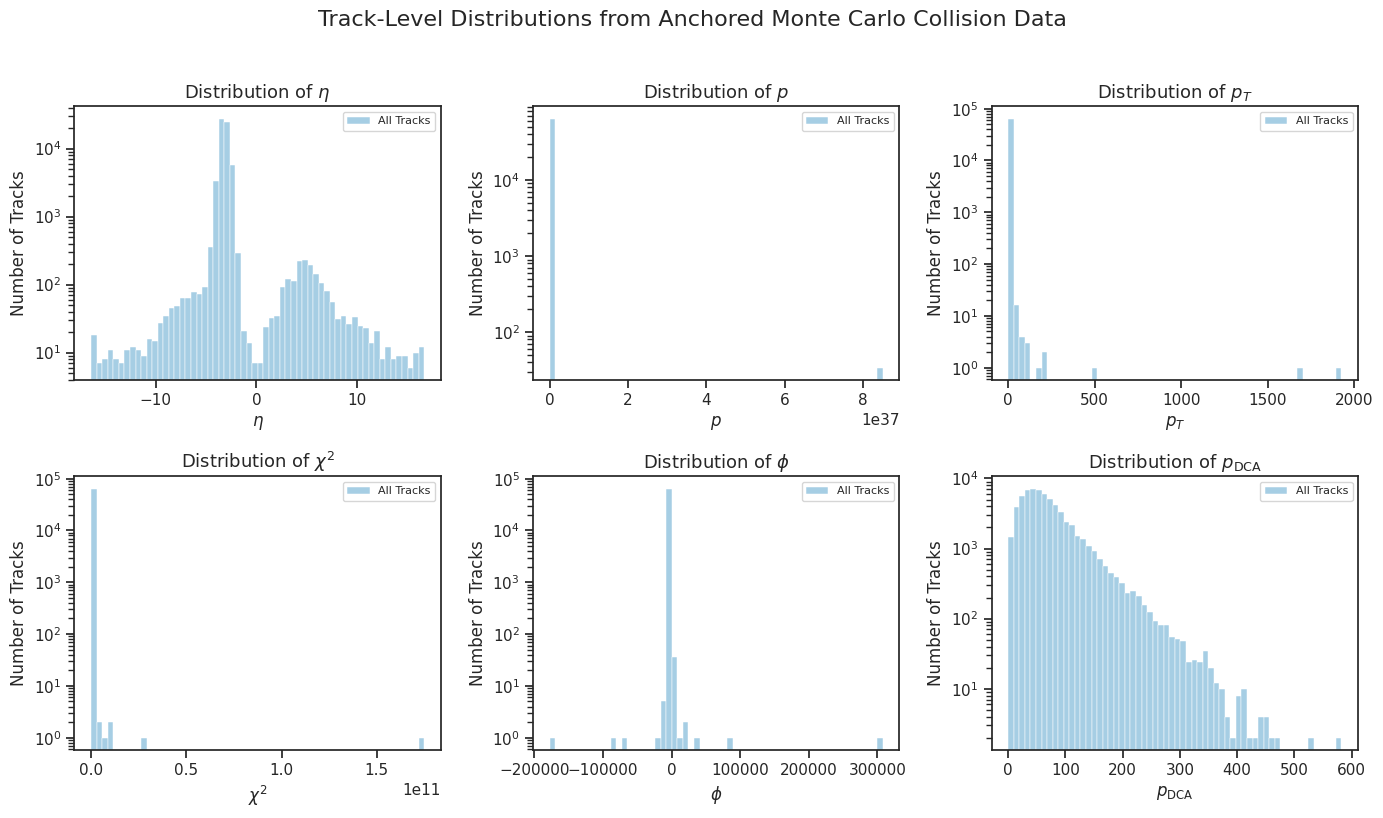

In [157]:
variables = {
    'eta': r'$\eta$',
    'p': r'$p$',
    'pt': r'$p_T$',
    'chi2': r'$\chi^2$',
    'phi': r'$\phi$',
    'pDca': r'$p_{\mathrm{DCA}}$'
}


sns.set_style("ticks")


fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()


color = sns.color_palette("Blues", 6)[0]


for ax, (col, label) in zip(axes, variables.items()):
    sns.histplot(df1[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[3], label='All Tracks')
    ax.set_yscale('log')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel('Number of Tracks', fontsize=12)
    ax.set_title(f'Distribution of {label}', fontsize=13)
    ax.legend(fontsize=8)
    ax.grid(False)


fig.suptitle('Track-Level Distributions from Anchored Monte Carlo Collision Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


In [158]:
signalPDG = [411, 421, 431,511, 521, 531, 541]
signal = []
background = []


for pdgx, val in enumerate(df1['motherPDG']):
    if val in signalPDG:
        signal.append(val)
    else:
        background.append(val)

print(f'Signal Entries:',len(signal))
print(f'Background Entries',len(background))

signalRows = []
backgroundRows = []

for _, row in df1.iterrows():
    if row['motherPDG'] in signalPDG:
        signalRows.append(row)
    else:
        backgroundRows.append(row)


dfSignal = pd.DataFrame(signalRows)
dfBackground = pd.DataFrame(backgroundRows)
ratioSB = len(signal)/len(background)

print(f'Ration of signal to background',ratioSB*100)
dfSignal

Signal Entries: 6644
Background Entries 57163
Ration of signal to background 11.622902926718332


,collisionID,trackID,mcID,eta,pt,p,phi,motherPDG,nClusters,trackType,pDca,chi2,chi2MatchMCHMID,isPrompt
10,354.0,12.0,270373.0,-3.27961,0.391250,5.20425,-2.726100,431.0,10.0,3.0,117.9410,0.251953,0.621094,1.0
11,354.0,13.0,270373.0,-3.50829,0.688866,11.51140,-2.954190,431.0,10.0,0.0,117.9410,165.000000,0.621094,1.0
14,477.0,16.0,361085.0,-3.44749,0.423797,6.66491,-2.051860,411.0,12.0,3.0,49.0469,0.133789,0.855469,1.0
15,477.0,17.0,361085.0,-3.26180,0.698142,9.12291,-2.134800,411.0,12.0,0.0,49.0469,24.250000,0.855469,1.0
50,1234.0,54.0,929075.0,-3.16937,0.780413,9.30041,-2.927350,421.0,10.0,2.0,70.4595,26752.000000,-1.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63754,660.0,67.0,1176908.0,-3.40701,0.355432,5.36844,-1.396510,411.0,10.0,0.0,18.3779,5.281250,3.765620,0.0
63765,79.0,8.0,154985.0,-3.96790,1.955130,51.70570,0.773345,411.0,10.0,3.0,123.2170,0.035156,0.953125,1.0
63766,79.0,9.0,154985.0,-3.68253,1.515770,30.14260,1.029650,411.0,10.0,0.0,123.2170,3280.000000,0.953125,1.0
63787,407.0,44.0,744534.0,-2.52347,0.848297,5.32390,-1.530820,431.0,10.0,3.0,76.7411,0.138672,0.812500,1.0


In [159]:
df1_filtered = df1[(df1['chi2'] <=2) & (df1['eta'] >= -4) & (df1['eta']<=-2.5) & (df1['trackType'] == 3) & (df1['p']>4) ].copy()#& (df1['p']>4)

iD = df1_filtered['collisionID'].to_numpy()
trackID = df1_filtered['trackID'].to_numpy()
mcID = df1_filtered['mcID'].to_numpy()
eta = df1_filtered['eta'].to_numpy()
pt = df1_filtered['pt'].to_numpy()
p = df1_filtered['p'].to_numpy()
phi = df1_filtered['phi'].to_numpy()
motherPDG = df1_filtered['motherPDG'].to_numpy()
nClusters = df1_filtered['nClusters'].to_numpy()
trackType = df1_filtered['trackType'].to_numpy()
pDca = df1_filtered['pDca'].to_numpy()
chi2 = df1_filtered['chi2'].to_numpy()
chi2MatchMCHMID = df1_filtered['chi2MatchMCHMID'].to_numpy()

In [160]:
df1_filtered.shape

(13200, 14)

In [161]:
df1_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13200 entries, 2 to 63805
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   collisionID      13200 non-null  int64  
 1   trackID          13200 non-null  int64  
 2   mcID             13200 non-null  int64  
 3   eta              13200 non-null  float64
 4   pt               13200 non-null  float64
 5   p                13200 non-null  float64
 6   phi              13200 non-null  float64
 7   motherPDG        13200 non-null  int64  
 8   nClusters        13200 non-null  int64  
 9   trackType        13200 non-null  int64  
 10  pDca             13200 non-null  float64
 11  chi2             13200 non-null  float64
 12  chi2MatchMCHMID  13200 non-null  float64
 13  isPrompt         13200 non-null  int64  
dtypes: float64(7), int64(7)
memory usage: 1.5 MB


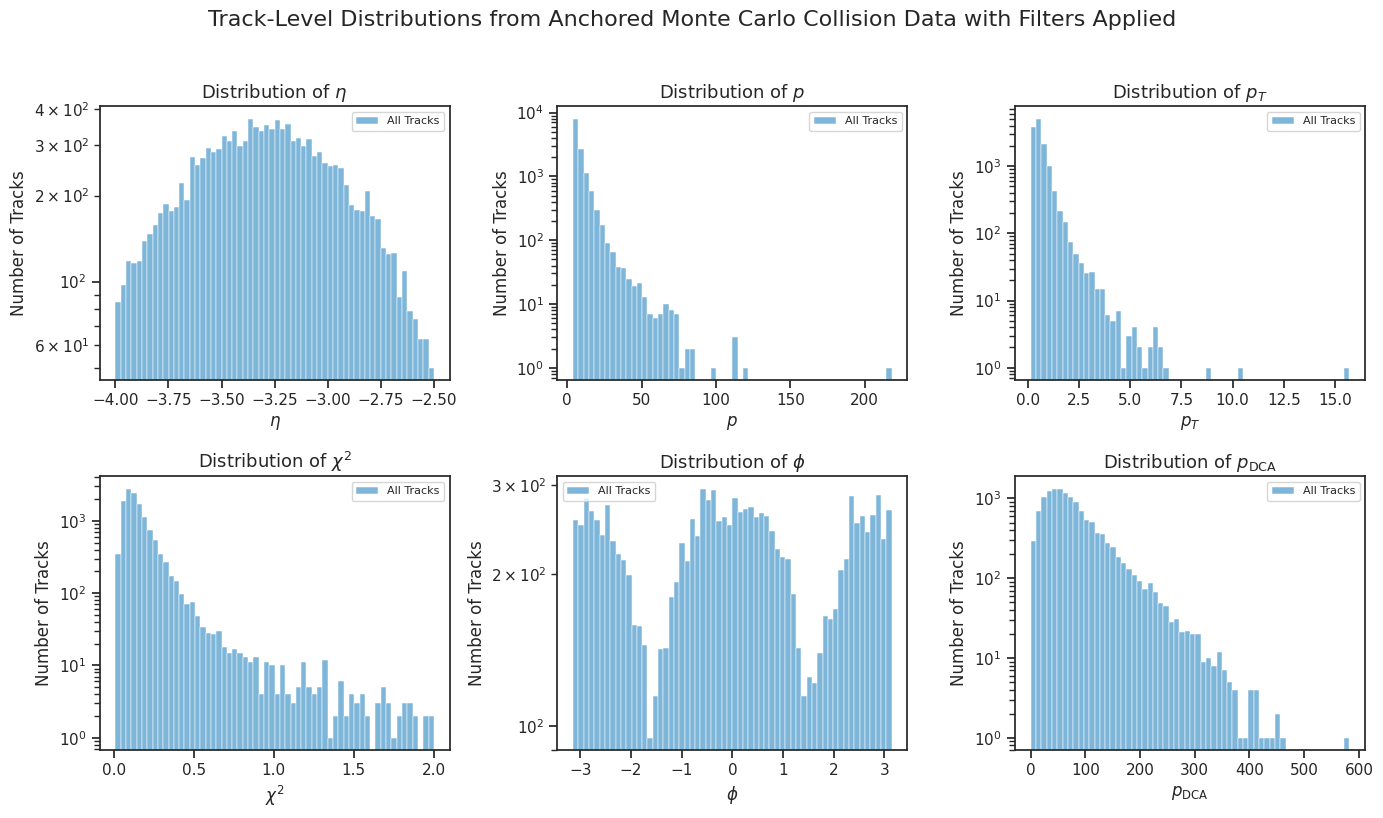

In [162]:
variables = {
    'eta': r'$\eta$',
    'p': r'$p$',
    'pt': r'$p_T$',
    'chi2': r'$\chi^2$',
    'phi': r'$\phi$',
    'pDca': r'$p_{\mathrm{DCA}}$'
}


sns.set_style("ticks")


fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()


color = sns.color_palette("Blues", 6)[0]


for ax, (col, label) in zip(axes, variables.items()):
    sns.histplot(df1_filtered[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[2], label='All Tracks')
    ax.set_yscale('log')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel('Number of Tracks', fontsize=12)
    ax.set_title(f'Distribution of {label}', fontsize=13)
    ax.legend(fontsize=8)
    ax.grid(False)


fig.suptitle('Track-Level Distributions from Anchored Monte Carlo Collision Data with Filters Applied', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


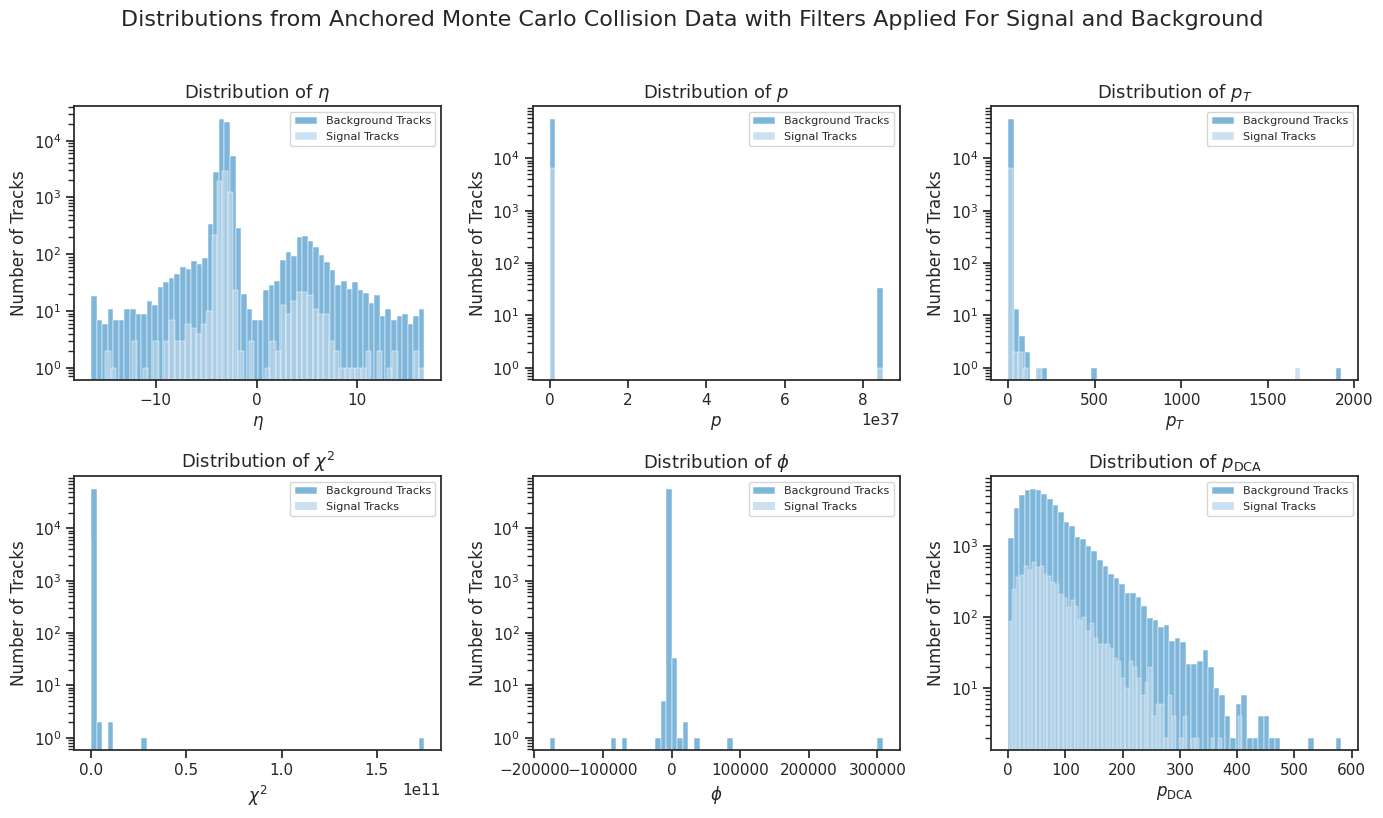

In [163]:
variables = {
    'eta': r'$\eta$',
    'p': r'$p$',
    'pt': r'$p_T$',
    'chi2': r'$\chi^2$',
    'phi': r'$\phi$',
    'pDca': r'$p_{\mathrm{DCA}}$'
}


sns.set_style("ticks")


fig, axes = plt.subplots(2, 3, figsize=(14, 8))
axes = axes.flatten()


color = sns.color_palette("Blues", 6)[0]


for ax, (col, label) in zip(axes, variables.items()):
    sns.histplot(dfBackground[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[2], label='Background Tracks')
    sns.histplot(dfSignal[col], bins=60, ax=ax, color=sns.color_palette("Blues_r")[4], label='Signal Tracks')
    ax.set_yscale('log')
    ax.set_xlabel(label, fontsize=12)
    ax.set_ylabel('Number of Tracks', fontsize=12)
    ax.set_title(f'Distribution of {label}', fontsize=13)
    ax.legend(fontsize=8)
    ax.grid(False)


fig.suptitle('Distributions from Anchored Monte Carlo Collision Data with Filters Applied For Signal and Background', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

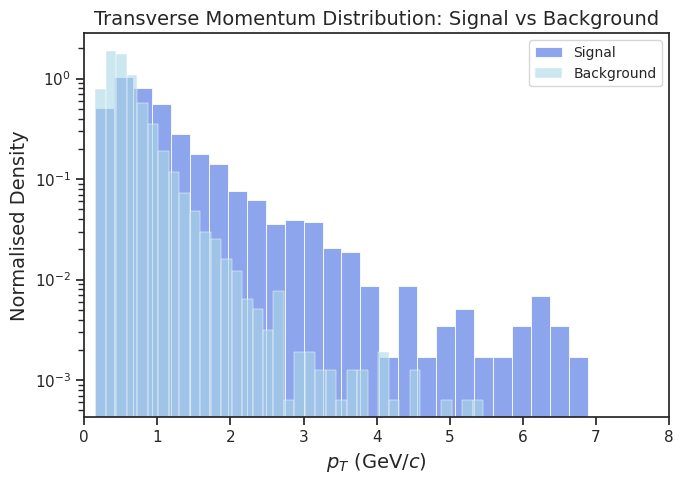

In [164]:

signalPDG = [511, 521, 531, 541, 411, 421, 431]
is_signal = df1_filtered['motherPDG'].isin(signalPDG)
is_background = ~is_signal

pt_signal = df1_filtered.loc[is_signal, 'pt']
pt_background = df1_filtered.loc[is_background, 'pt']

sns.set_style("ticks")

plt.figure(figsize=(7,5))
sns.histplot(pt_signal, bins=60, color='royalblue', label='Signal', stat='density', alpha=0.6)
sns.histplot(pt_background, bins=60, color='lightblue', label='Background', stat='density', alpha=0.6)

plt.yscale('log')
plt.xlabel(r'$p_T$ (GeV/$c$)', fontsize=14)
plt.xlim(0,8)
plt.ylabel('Normalised Density', fontsize=14)
plt.title('Transverse Momentum Distribution: Signal vs Background', fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()


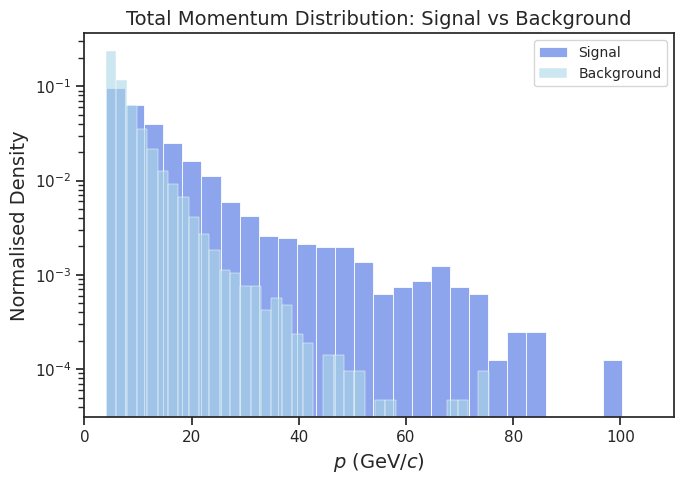

In [165]:
signalPDG = [511, 521, 531, 541, 411, 421, 431]

is_signal = df1_filtered['motherPDG'].isin(signalPDG)
is_background = ~is_signal


p_signal = df1_filtered.loc[is_signal, 'p']
p_background = df1_filtered.loc[is_background, 'p']

sns.set_style("ticks")

plt.figure(figsize=(7,5))
sns.histplot(p_signal, bins=60, color='royalblue', label='Signal', stat='density', alpha=0.6)
sns.histplot(p_background, bins=60, color='lightblue', label='Background', stat='density', alpha=0.6)

plt.yscale('log')
plt.xlabel(r'$p$ (GeV/$c$)', fontsize=14)
plt.xlim(0,110)
plt.ylabel('Normalised Density', fontsize=14)
plt.title('Total Momentum Distribution: Signal vs Background', fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()

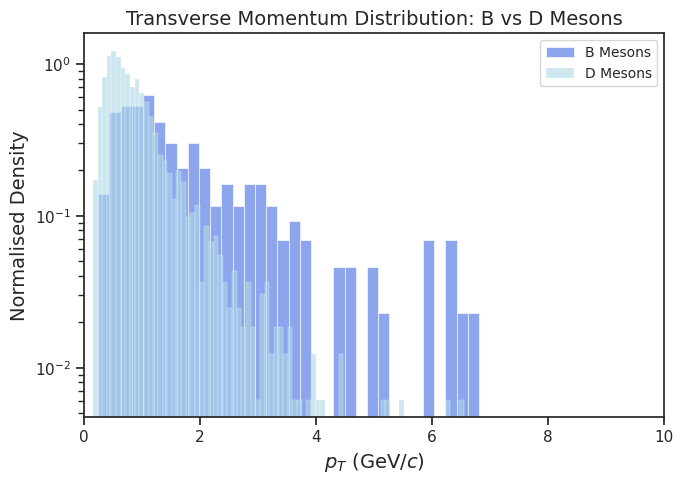

In [166]:
B = [511, 521, 531, 541]   # B mesons
D = [411, 421, 431]

df1_filtered['motherPDG'] = pd.to_numeric(df1_filtered['motherPDG'], errors='coerce')

mask_B = df1_filtered['motherPDG'].isin(B)
mask_D = df1_filtered['motherPDG'].isin(D)

pt_B = df1_filtered.loc[mask_B, 'pt'].dropna()
pt_D = df1_filtered.loc[mask_D, 'pt'].dropna()

plt.figure(figsize=(7,5))
sns.histplot(pt_B, bins=80, color='royalblue', label='B Mesons', stat='density', alpha=0.6)
sns.histplot(pt_D, bins=80, color='lightblue', label='D Mesons', stat='density', alpha=0.6)

plt.yscale('log')
plt.xlabel(r'$p_T$ (GeV/$c$)', fontsize=14)
plt.xlim(0,10)
plt.ylabel('Normalised Density', fontsize=14)
plt.title('Transverse Momentum Distribution: B vs D Mesons', fontsize=14)
plt.legend(fontsize=10)
plt.grid(False)
plt.tight_layout()
plt.show()


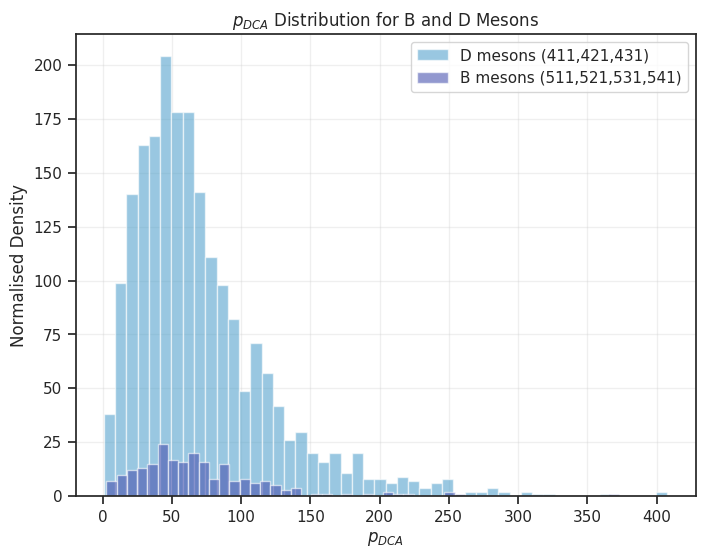

In [167]:
group_B = [511, 521, 531, 541]   # B mesons
group_D = [411, 421, 431]        # D mesons

df_B = df1_filtered[df1_filtered['motherPDG'].isin(group_B)]
df_D = df1_filtered[df1_filtered['motherPDG'].isin(group_D)]

plt.figure(figsize=(8,6))
plt.hist(df_D['pDca'], bins=50, alpha=0.6, label='D mesons (411,421,431)')
plt.hist(df_B['pDca'], bins=50, alpha=0.6, label='B mesons (511,521,531,541)')


plt.xlabel(r'$p_{DCA}$')
plt.ylabel("Normalised Density")
plt.title(r"$p_{DCA}$ Distribution for B and D Mesons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

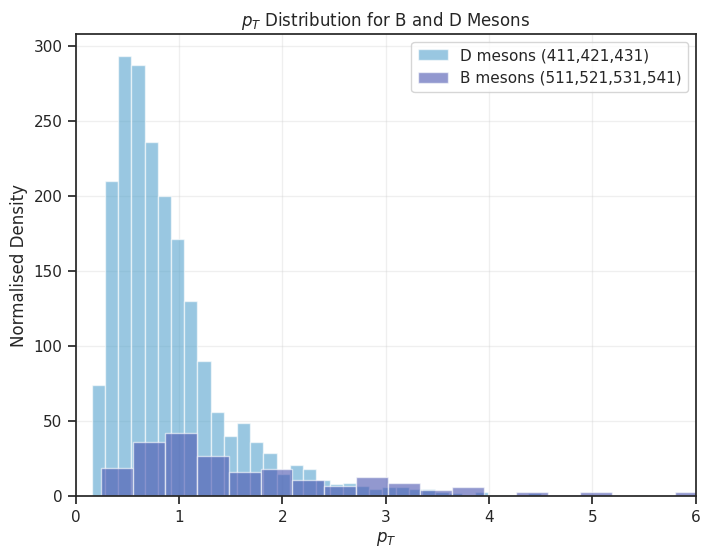

In [168]:
group_B = [511, 521, 531, 541]   # B mesons
group_D = [411, 421, 431]        # D mesons

df_B = df1_filtered[df1_filtered['motherPDG'].isin(group_B)]
df_D = df1_filtered[df1_filtered['motherPDG'].isin(group_D)]

plt.figure(figsize=(8,6))
plt.hist(df_D['pt'], bins=50, alpha=0.6, label='D mesons (411,421,431)')
plt.hist(df_B['pt'], bins=50, alpha=0.6, label='B mesons (511,521,531,541)')


plt.xlabel(r'$p_{T}$')
plt.ylabel("Normalised Density")
plt.xlim(0,6)
plt.title(r"$p_{T}$ Distribution for B and D Mesons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [169]:
signalPDG = [411, 421, 431,511, 521, 531, 541]
signal = []
background = []


for pdgx, val in enumerate(df1_filtered['motherPDG']):
    if val in signalPDG:
        signal.append(val)
    else:
        background.append(val)

print(f'Signal Entries:',len(signal))
print(f'Background Entries',len(background))

signalRows = []
backgroundRows = []

for _, row in df1_filtered.iterrows():
    if row['motherPDG'] in signalPDG:
        signalRows.append(row)
    else:
        backgroundRows.append(row)


dfSignal = pd.DataFrame(signalRows)
dfBackground = pd.DataFrame(backgroundRows)
ratioSB = len(signal)/len(background)

print(f'Ratio of signal to background',ratioSB*100)
dfSignal

print(np.unique(dfSignal['motherPDG']))
print(np.unique(dfBackground['motherPDG']))

Signal Entries: 2259
Background Entries 10941
Ratio of signal to background 20.647107211406635
[411. 421. 431. 511. 521. 531.]
[  15.  113.  130.  211.  221.  223.  321.  331.  333.  443. 2212. 4122.
 4132. 4232. 5122. 5232.]


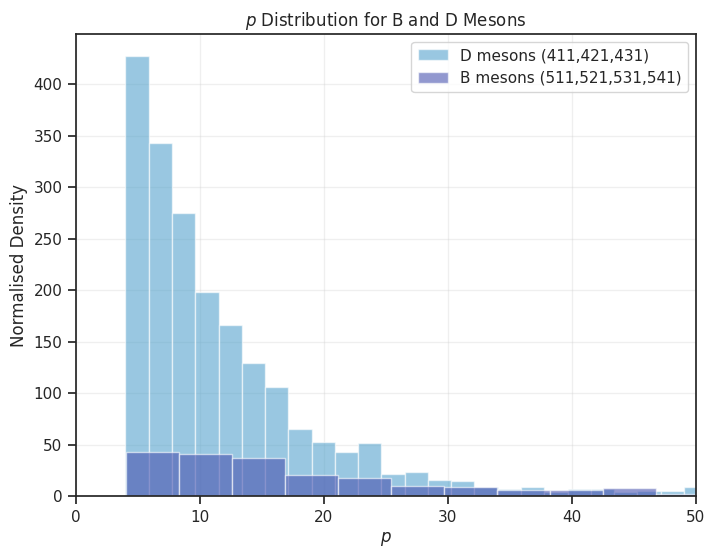

In [170]:
group_B = [511, 521, 531, 541]   # B mesons
group_D = [411, 421, 431]        # D mesons


df_B = df1_filtered[df1_filtered['motherPDG'].isin(group_B)]
df_D = df1_filtered[df1_filtered['motherPDG'].isin(group_D)]

plt.figure(figsize=(8,6))
#plt.hist(dfBackground['p'], bins =50, alpha = 0.3, color ='green', label = 'All Background')
plt.hist(df_D['p'], bins=50, alpha=0.6, label='D mesons (411,421,431)')
plt.hist(df_B['p'], bins=50, alpha=0.6, label='B mesons (511,521,531,541)')


plt.xlabel(r'$p$')
plt.ylabel("Normalised Density")
plt.xlim(0,50)
plt.title(r"$p$ Distribution for B and D Mesons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

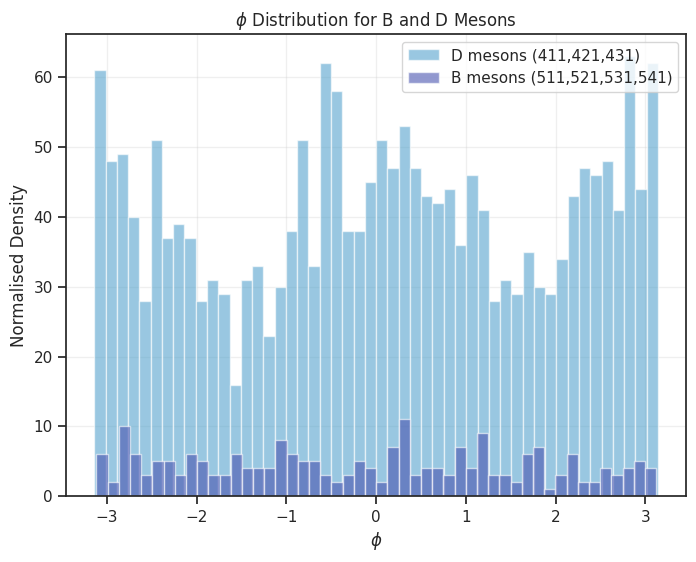

In [171]:
group_B = [511, 521, 531, 541]   # B mesons
group_D = [411, 421, 431]        # D mesons


df_B = df1_filtered[df1_filtered['motherPDG'].isin(group_B)]
df_D = df1_filtered[df1_filtered['motherPDG'].isin(group_D)]

plt.figure(figsize=(8,6))
#plt.hist(dfBackground['p'], bins =50, alpha = 0.3, color ='green', label = 'All Background')
plt.hist(df_D['phi'], bins=50, alpha=0.6, label='D mesons (411,421,431)')
plt.hist(df_B['phi'], bins=50, alpha=0.6, label='B mesons (511,521,531,541)')


plt.xlabel(r'$\phi$')
plt.ylabel("Normalised Density")

plt.title(r"$\phi$ Distribution for B and D Mesons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

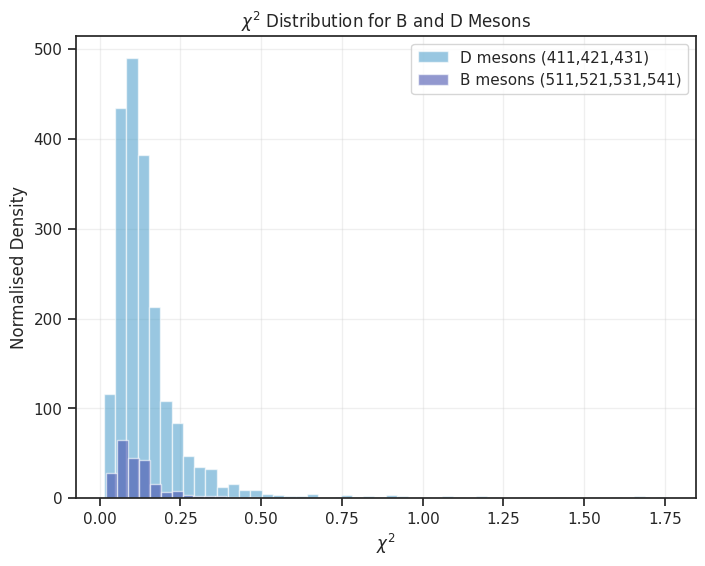

In [172]:
group_B = [511, 521, 531, 541]   # B mesons
group_D = [411, 421, 431]        # D mesons

df_B = df1_filtered[df1_filtered['motherPDG'].isin(group_B)]
df_D = df1_filtered[df1_filtered['motherPDG'].isin(group_D)]

plt.figure(figsize=(8,6))
#plt.hist(dfBackground['p'], bins =50, alpha = 0.3, color ='green', label = 'All Background')
plt.hist(df_D['chi2'], bins=50, alpha=0.6, label='D mesons (411,421,431)')
plt.hist(df_B['chi2'], bins=50, alpha=0.6, label='B mesons (511,521,531,541)')


plt.xlabel(r'$\chi^2$')
plt.ylabel("Normalised Density")

plt.title(r"$\chi^2$ Distribution for B and D Mesons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

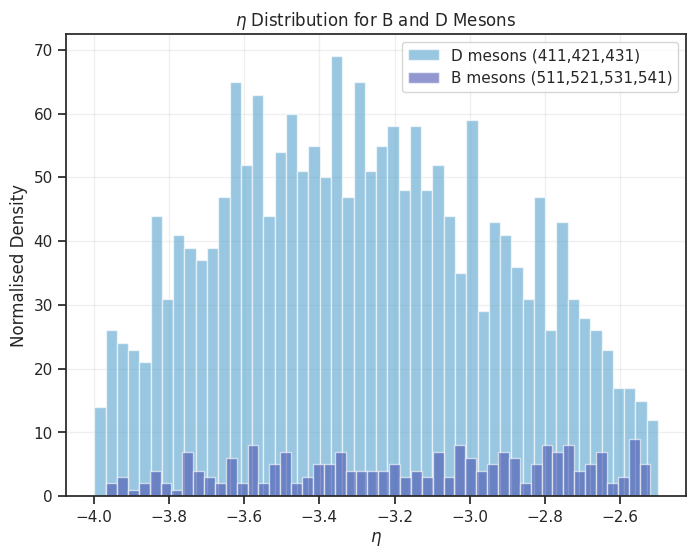

In [173]:
group_B = [511, 521, 531, 541]   # B mesons
group_D = [411, 421, 431]        # D mesons


df_B = df1_filtered[df1_filtered['motherPDG'].isin(group_B)]
df_D = df1_filtered[df1_filtered['motherPDG'].isin(group_D)]

plt.figure(figsize=(8,6))
#plt.hist(dfBackground['p'], bins =50, alpha = 0.3, color ='green', label = 'All Background')
plt.hist(df_D['eta'], bins=50, alpha=0.6, label='D mesons (411,421,431)')
plt.hist(df_B['eta'], bins=50, alpha=0.6, label='B mesons (511,521,531,541)')


plt.xlabel(r'$\eta$')
plt.ylabel("Normalised Density")

plt.title(r"$\eta$ Distribution for B and D Mesons")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [174]:
#Add a label column to set to identify signal particles with a value s and background particles with a value b

label = []
#iterrows() -> used to iterate over the rows of a DataFrame. It returns a generator that yields pairs of (index, Series) for each row.
for index, row in df1_filtered.iterrows():
  if row['motherPDG'] in signalPDG:
    label.append('s')
  else:
    label.append('b')

df1_filtered['label'] = label

df1_filtered
print(df1_filtered.info())


<class 'pandas.core.frame.DataFrame'>
Index: 13200 entries, 2 to 63805
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   collisionID      13200 non-null  int64  
 1   trackID          13200 non-null  int64  
 2   mcID             13200 non-null  int64  
 3   eta              13200 non-null  float64
 4   pt               13200 non-null  float64
 5   p                13200 non-null  float64
 6   phi              13200 non-null  float64
 7   motherPDG        13200 non-null  int64  
 8   nClusters        13200 non-null  int64  
 9   trackType        13200 non-null  int64  
 10  pDca             13200 non-null  float64
 11  chi2             13200 non-null  float64
 12  chi2MatchMCHMID  13200 non-null  float64
 13  isPrompt         13200 non-null  int64  
 14  label            13200 non-null  object 
dtypes: float64(7), int64(7), object(1)
memory usage: 1.6+ MB
None


In [175]:

#Adding a new col y here (realted to label) - if label is s then y col gets a 1
#.astype(int)- is used to convert the data type of a Series, DataFrame column, or NumPy array to an integer type.
df1_filtered["y"] = (df1_filtered["label"] == "s").astype(int)


In [176]:
# from sklearn.model_selection import train_test_split
# #stratify = df1_filtered['motherPDG']
# training_df, testing_df = train_test_split(df1_filtered, test_size=0.2, random_state=42)

from sklearn.model_selection import train_test_split

# Step 1: Get unique collisionIDs
unique_ids = df1_filtered["collisionID"].unique()

# Step 2: Split those IDs
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=0)

# Step 3: Create training and testing sets based on those IDs
training_df = df1_filtered[df1_filtered["collisionID"].isin(train_ids)]
testing_df = df1_filtered[df1_filtered["collisionID"].isin(test_ids)]

In [177]:
# Calculate the signal/background ratio in the training set
training_signal_count = training_df[training_df['motherPDG'].isin(signalPDG)].shape[0]
training_background_count = training_df[~training_df['motherPDG'].isin(signalPDG)].shape[0]
training_ratio_SB = training_signal_count / training_background_count if training_background_count > 0 else 0
print(f"Training set Signal/Background Ratio: {training_ratio_SB*100:.2f}%")

# Calculat the signal/background ratio in the testing set
testing_signal_count = testing_df[testing_df['motherPDG'].isin(signalPDG)].shape[0]
testing_background_count = testing_df[~testing_df['motherPDG'].isin(signalPDG)].shape[0]
testing_ratio_SB = testing_signal_count / testing_background_count if testing_background_count > 0 else 0
print(f"Testing set Signal/Background Ratio: {testing_ratio_SB*100:.2f}%")

# Calculat the signal/background ratio in the original filtered data
original_signal_count = df1_filtered[df1_filtered['motherPDG'].isin(signalPDG)].shape[0]
original_background_count = df1_filtered[~df1_filtered['motherPDG'].isin(signalPDG)].shape[0]
original_ratio_SB = original_signal_count / original_background_count if original_background_count > 0 else 0
print(f"Original filtered data Signal/Background Ratio: {original_ratio_SB*100:.2f}%")


Training set Signal/Background Ratio: 20.97%
Testing set Signal/Background Ratio: 19.43%
Original filtered data Signal/Background Ratio: 20.65%


In [178]:
from sklearn.utils.class_weight import compute_class_weight
 #This function calculates weights for each class in a classification problem to help balance datasets that are imbalanced
 #(i.e., some classes appear more often than others).

 #np.unique(...) finds all unique class labels in y.
classes = np.unique(training_df["y"])

#class_weight="balanced": automatically adjusts the weights inversely proportional to class frequencies, so rare classes get higher weight.
#classes=classes: the list of all unique classes.
#y=training_df["y"]: the array of actual class labels.

class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=training_df["y"])

#zip(classes, class_weights) pairs each class with its corresponding weight.
#dict(...) converts these pairs into a dictionary.
#Result: class_weights_dict might look like {0: 2.0, 1: 0.67}.
class_weights_dict = dict(zip(classes, class_weights))

print("Class weight Background:", class_weights_dict[0])
print("Class weight Signal:", class_weights_dict[1])

training_df = training_df.copy()
training_df['w'] = training_df['y'].map(class_weights_dict)

training_df.head(8)

Class weight Background: 0.604840573012939
Class weight Signal: 2.884573002754821


,collisionID,trackID,mcID,eta,pt,p,phi,motherPDG,nClusters,trackType,pDca,chi2,chi2MatchMCHMID,isPrompt,label,y,w
2,125,2,102667,-3.41393,0.858880,13.06240,2.801200,321,12,3,44.9307,0.144531,0.554688,1,b,0,0.604841
6,218,6,171002,-2.93607,0.560673,5.29689,1.075610,321,10,3,140.5290,0.210938,1.062500,1,b,0,0.604841
8,252,10,197209,-3.73895,0.510914,10.74910,0.096842,321,10,3,51.1675,0.232422,1.304690,1,b,0,0.604841
10,354,12,270373,-3.27961,0.391250,5.20425,-2.726100,431,10,3,117.9410,0.251953,0.621094,1,s,1,2.884573
20,719,22,540836,-3.46161,0.574716,9.16664,-0.345634,321,12,3,134.2360,0.092773,0.703125,1,b,0,0.604841
34,877,38,657418,-2.95560,0.560175,5.39596,2.508450,211,10,3,105.3500,0.173828,1.203120,0,b,0,0.604841
40,1048,44,794431,-3.42910,0.450159,6.95075,-0.699739,211,9,3,72.4956,0.253906,0.349609,1,b,0,0.604841
48,1234,52,929289,-3.73591,0.212669,4.46073,-2.836690,211,10,3,128.8290,0.185547,1.765620,1,b,0,0.604841


In [179]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.utils.class_weight import compute_class_weight


FEATURE_EXCLUDE = ["collisionID","trackID","mcID","motherPDG","trackType","nClusters","chi2MatchMCHMID", "isPrompt", "label" ,"w", "y"]
features = [c for c in training_df.columns if c not in FEATURE_EXCLUDE]


X_raw = training_df[features].copy()
y = training_df["y"].values
w = training_df["w"].values

X_test_raw = testing_df[features].copy()
y_test = testing_df["y"].values


X_train_raw, X_val_train, y_train, y_val,w_train, w_val = train_test_split(X_raw, y, w, test_size=0.2, random_state=42, stratify=y)

imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train_raw)
X_val_imputed = imputer.transform(X_val_train)
X_test_imputed = imputer.transform(X_test_raw)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

X_train = X_train_scaled
X_test = X_test_scaled
X_val = X_val_scaled

print("Num features:", len(features))
print(features)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)


Num features: 6
['eta', 'pt', 'p', 'phi', 'pDca', 'chi2']
(8376, 6)
(2095, 6)
(2729, 6)


In [180]:
train_indices = X_train_raw.index
val_indices = X_val_train.index
test_indices = X_test_raw.index

print("Train & Val overlap:", train_indices.intersection(val_indices).any())
print("Train & Test overlap:", train_indices.intersection(test_indices).any())
print("Val & Test overlap:", val_indices.intersection(test_indices).any())


Train & Val overlap: False
Train & Test overlap: False
Val & Test overlap: False


In [181]:
import numpy as np


unique, counts = np.unique(y_train, return_counts=True)
counts_dict = dict(zip(unique, counts))
print("Counts Background:", counts_dict[0])
print("Counts Signal:", counts_dict[1])

signal = counts_dict.get(1, 0)
background = counts_dict.get(0, 0)
ratio = signal / background
print(f"Signal:Background = {signal}:{background} ≈ {ratio:.3f}")

Counts Background: 6924
Counts Signal: 1452
Signal:Background = 1452:6924 ≈ 0.210


In [218]:
from sklearn.linear_model import LogisticRegression #LogisticRegression: a linear classification model for binary or multi-class problems.
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, confusion_matrix, roc_curve, precision_recall_curve

logit = LogisticRegression(max_iter=5000)  # robust default solver

logit.fit(X_train, y_train, sample_weight=w_train)

proba_val_lr = logit.predict_proba(X_val)[:,1]



pred_val_lr = (proba_val_lr >= 0.45).astype(int)


metrics_lr = {
    "Accuracy": accuracy_score(y_val, pred_val_lr, sample_weight=w_val),
    "F1": f1_score(y_val, pred_val_lr, sample_weight=w_val),#Harmonic mean of precision (how many predicted positives are correct) and recall (how many actual positives are detected).Good value: closer to 1 is better.
    "ROC_AUC": roc_auc_score(y_val, proba_val_lr, sample_weight=w_val),#Measures the model’s ability to distinguish between classes at all possible thresholds.0.8–0.9 → good
    "ConfusionMatrix": confusion_matrix(y_val, pred_val_lr, sample_weight=w_val)
}
metrics_lr



{'Accuracy': 0.6605885924067743,
 'F1': 0.6430406051494982,
 'ROC_AUC': np.float64(0.7158367211904845),
 'ConfusionMatrix': array([[743.34906423, 304.23480823],
        [406.72479339, 640.37520661]])}

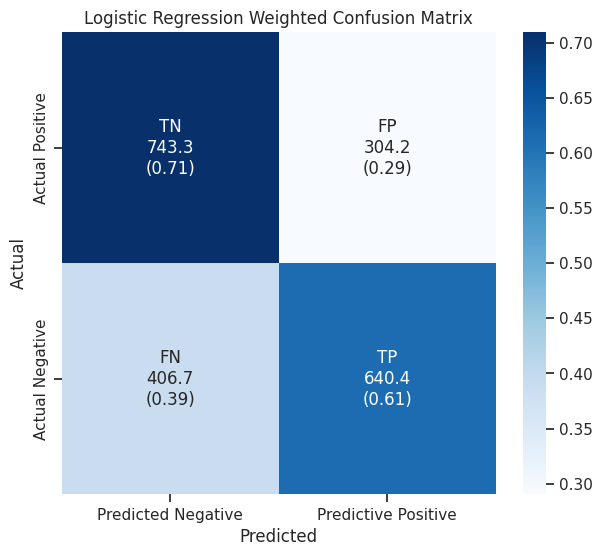

In [183]:
cm = metrics_lr["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Blues",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Weighted Confusion Matrix")
plt.show()

/tmp/ipython-input-2913583255.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)


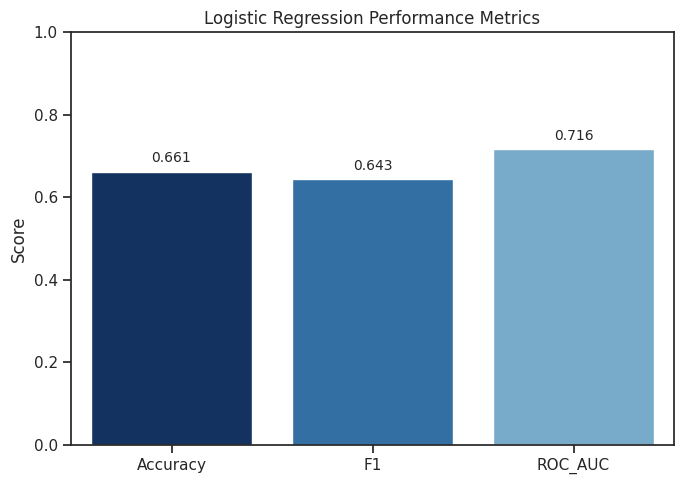

In [184]:
scalar_metrics = {k: v for k, v in metrics_lr.items() if k != "ConfusionMatrix"}
metrics_names = list(scalar_metrics.keys())
metrics_values = list(scalar_metrics.values())

palette = ["#08306b", "#2171b5", "#6baed6"]

plt.figure(figsize=(7,5))
bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)

for bar, value in zip(bars.patches, metrics_values):
    height = bar.get_height()
    bars.annotate(f"{value:.3f}",
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=10)

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Logistic Regression Performance Metrics")
plt.tight_layout()
plt.show()



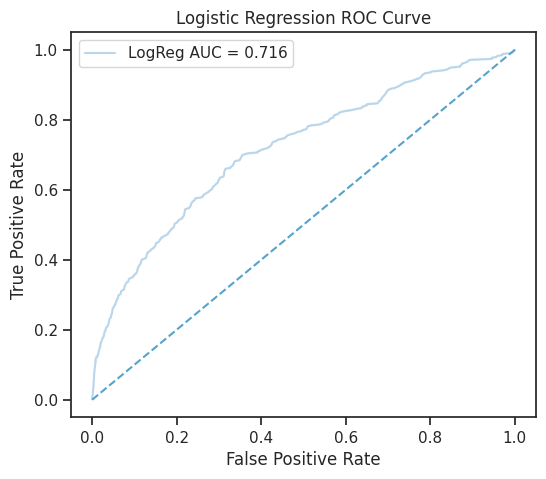

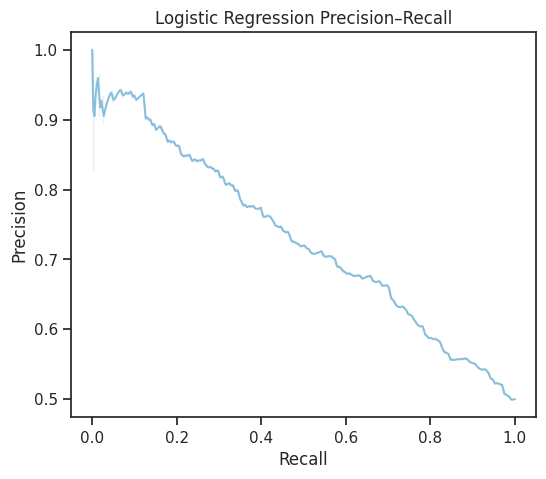

Weighted confusion matrix (threshold=0.45):
 [[743.34906423 304.23480823]
 [406.72479339 640.37520661]]


In [185]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_val, proba_val_lr, sample_weight=w_val)

plt.figure(figsize=(6,5))
sns.lineplot(x=fpr, y=tpr, color = sns.color_palette("Blues_r")[4], label=f"LogReg AUC = {roc_auc_score(y_val, proba_val_lr, sample_weight=w_val):.3f}")
plt.plot([0,1],[0,1],'--') #Plots a diagonal dashed line representing a random classifier baseline.
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve");
plt.grid(False)
plt.legend();
plt.show()

# Precision–Recall
prec, rec, thr = precision_recall_curve(y_val, proba_val_lr, sample_weight=w_val)
plt.figure(figsize=(6,5))
sns.lineplot(x=rec, y=prec, color = sns.color_palette("Blues")[2])
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.grid(False)
plt.title("Logistic Regression Precision–Recall");
plt.show()

print("Weighted confusion matrix (threshold=0.45):\n", metrics_lr["ConfusionMatrix"])

  Feature  Coefficient
1      pt     0.665156
2       p     0.423084
0     eta     0.026579
3    pDca     0.011675
5    chi2    -0.050303
4     phi    -0.275574


/tmp/ipython-input-4193808319.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='crest')


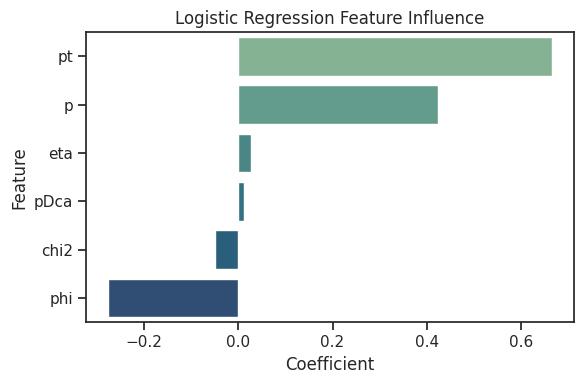

In [186]:

feature_names = ['eta', 'pt', 'p',  'pDca','phi', 'chi2']

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': logit.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

print(feature_importance)



plt.figure(figsize=(6,4))
sns.barplot(data=feature_importance, x='Coefficient', y='Feature', palette='crest')
plt.title('Logistic Regression Feature Influence')
plt.tight_layout()
plt.show()


  Feature  Abs_Coefficient
1      pt         0.665156
2       p         0.423084
4    pDca         0.275574
5    chi2         0.050303
0     eta         0.026579
3     phi         0.011675


/tmp/ipython-input-3709278655.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_abs, x='Abs_Coefficient', y='Feature', palette='crest')


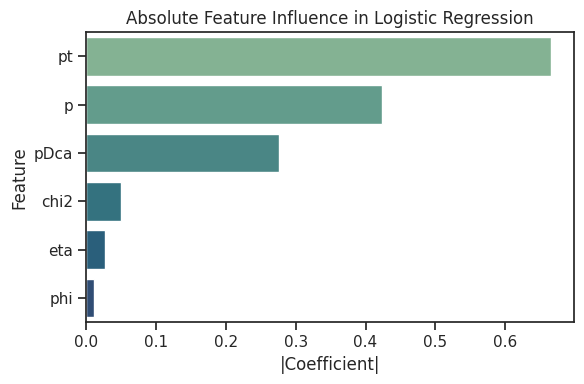

In [187]:
feature_names = ['eta', 'pt', 'p', 'phi', 'pDca', 'chi2']

feature_importance_abs = pd.DataFrame({
    'Feature': feature_names,
    'Abs_Coefficient': np.abs(logit.coef_[0])
}).sort_values(by='Abs_Coefficient', ascending=False)

print(feature_importance_abs)

# Plot
plt.figure(figsize=(6,4))
sns.barplot(data=feature_importance_abs, x='Abs_Coefficient', y='Feature', palette='crest')
plt.title('Absolute Feature Influence in Logistic Regression')
plt.xlabel('|Coefficient|')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [219]:
logitTest = LogisticRegression(max_iter=5000)  # robust default solver

logitTest.fit(X_test, y_test)

proba_val_lrTest = logitTest.predict_proba(X_test)[:,1]


pred_val_lrTest = (proba_val_lrTest >= 0.45).astype(int)


metrics_lrTest = {
    "Accuracy": accuracy_score(y_test, pred_val_lrTest),
    "F1": f1_score(y_test, pred_val_lrTest),#Harmonic mean of precision (how many predicted positives are correct) and recall (how many actual positives are detected).Good value: closer to 1 is better.
    "ROC_AUC": roc_auc_score(y_test, proba_val_lrTest),#Measures the model’s ability to distinguish between classes at all possible thresholds.0.8–0.9 → good
    "ConfusionMatrix": confusion_matrix(y_test, pred_val_lrTest)
}
metrics_lrTest


{'Accuracy': 0.8438988640527666,
 'F1': 0.22826086956521738,
 'ROC_AUC': np.float64(0.7345979458670925),
 'ConfusionMatrix': array([[2240,   45],
        [ 381,   63]])}

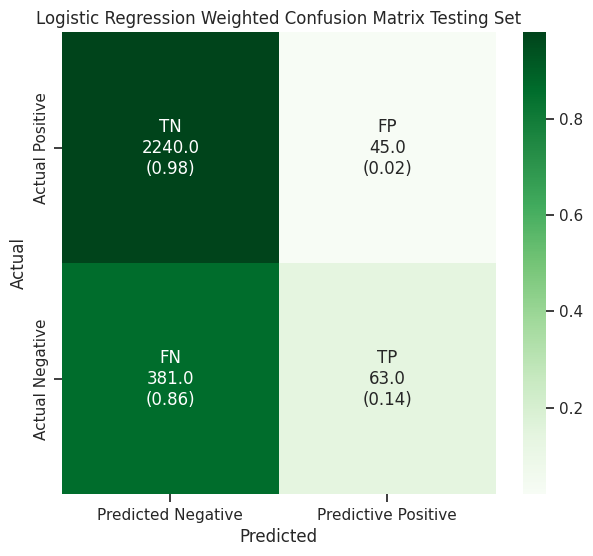

In [220]:
cm = metrics_lrTest["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Greens",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Logistic Regression Weighted Confusion Matrix Testing Set")
plt.show()

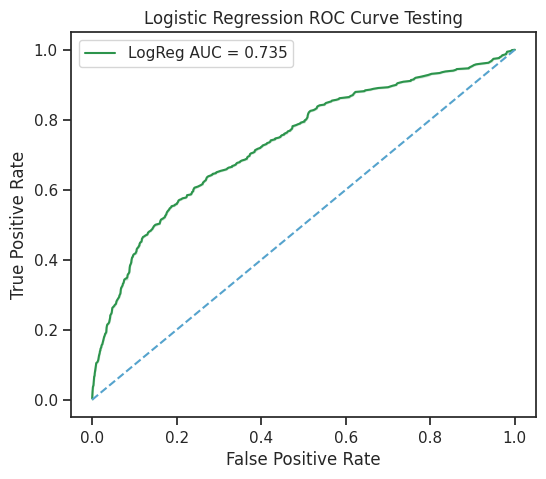

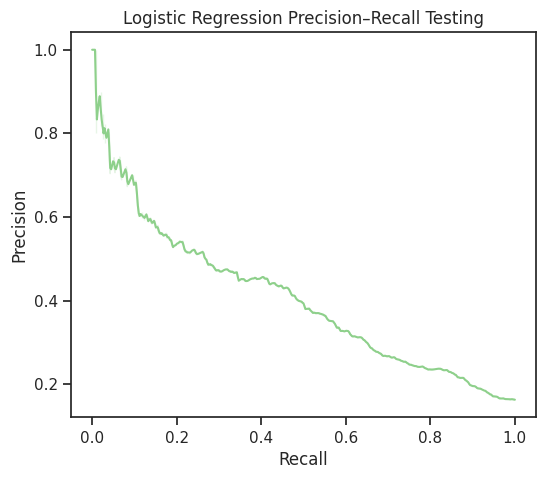

Weighted confusion matrix (threshold=0.45):
 [[743.34906423 304.23480823]
 [406.72479339 640.37520661]]


In [221]:
# ROC Curve
fprTest, tprTest, thresholdsTest = roc_curve(y_test, proba_val_lrTest)

plt.figure(figsize=(6,5))
sns.lineplot(x=fprTest, y=tprTest, color = sns.color_palette("Greens")[4], label=f"LogReg AUC = {roc_auc_score(y_test, proba_val_lrTest):.3f}")
plt.plot([0,1],[0,1],'--') #Plots a diagonal dashed line representing a random classifier baseline.
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve Testing");
plt.grid(False)
plt.legend();
plt.show()

# Precision–Recall
precTest, recTest, thrTest = precision_recall_curve(y_test, proba_val_lrTest)
plt.figure(figsize=(6,5))
sns.lineplot(x=recTest, y=precTest, color = sns.color_palette("Greens")[2])
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.grid(False)
plt.title("Logistic Regression Precision–Recall Testing");
plt.show()

print("Weighted confusion matrix (threshold=0.45):\n", metrics_lr["ConfusionMatrix"])

/tmp/ipython-input-1979444093.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)


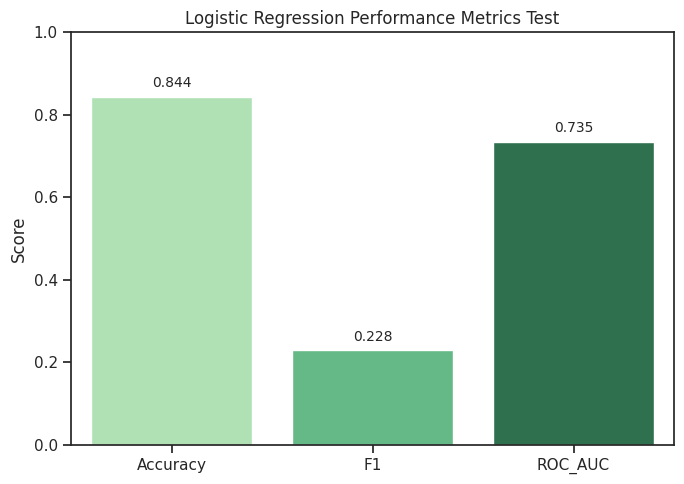

In [191]:
scalar_metricsTest = {k: v for k, v in metrics_lrTest.items() if k != "ConfusionMatrix"}
metrics_namesTest = list(scalar_metricsTest.keys())
metrics_valuesTest = list(scalar_metricsTest.values())

green_palette = ["#A7E9AF", "#57C785", "#247B4D"]
plt.figure(figsize=(7,5))
barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)

for bar, value in zip(barsTest.patches, metrics_valuesTest):
    height = bar.get_height()
    barsTest.annotate(f"{value:.3f}",
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=10)

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Logistic Regression Performance Metrics Test")
plt.tight_layout()
plt.show()



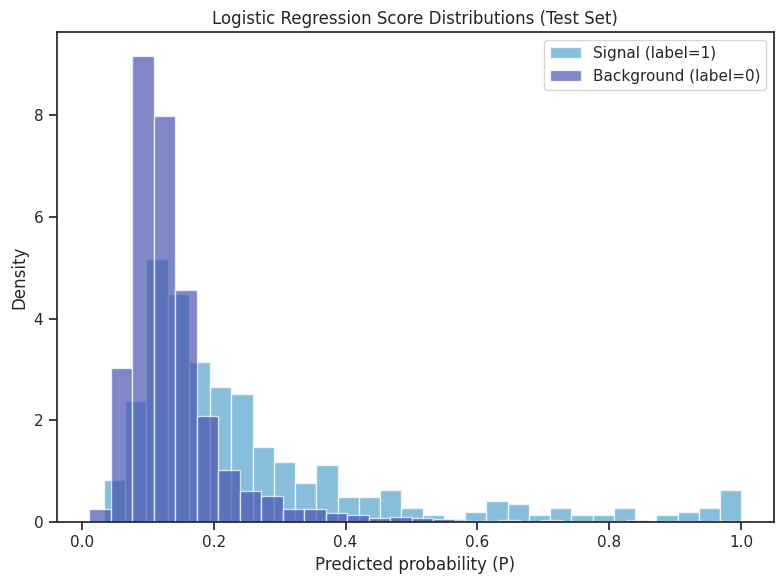

In [192]:
signal_scores = proba_val_lrTest[y_test == 1]
background_scores = proba_val_lrTest[y_test == 0]

plt.figure(figsize=(8,6))
plt.hist(signal_scores, bins=30, density=True, alpha=0.7, label='Signal (label=1)')
plt.hist(background_scores, bins=30, density=True, alpha=0.7, label='Background (label=0)')

plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Logistic Regression Score Distributions (Test Set)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


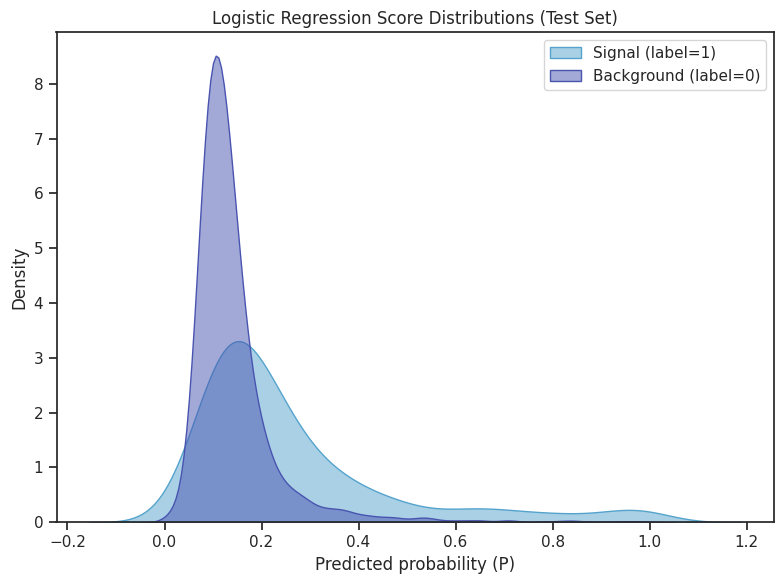

In [193]:
plt.figure(figsize=(8,6))
sns.kdeplot(signal_scores, label='Signal (label=1)', fill=True, alpha=0.5)
sns.kdeplot(background_scores, label='Background (label=0)', fill=True, alpha=0.5)
plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Logistic Regression Score Distributions (Test Set)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

In [194]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

# Clears any previously built models/graphs from memory
# (good practice to avoid clutter when re-running code)
keras.backend.clear_session()


# Define a function to build a Multi-Layer Perceptron (MLP) model
def make_mlp(input_dim, hidden=[16,16,16], drop=0.2, l2=0.0):

    inputs = keras.Input(shape=(input_dim,), name="features")

    x = inputs

    for i, h in enumerate(hidden, start=1):
        x = layers.Dense(
            h,
            activation="relu",
            kernel_regularizer=regularizers.l2(l2),
            name=f"dense_{i}"
        )(x)

        x = layers.BatchNormalization(name=f"bn_{i}")(x)

        x = layers.Dropout(drop, name=f"drop_{i}")(x)

    outputs = layers.Dense(1, activation="sigmoid", name="logit")(x)

    model = keras.Model(inputs, outputs, name="ALICE_HEAVY_FLAVOUR_MUONS_MLP")

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.AUC(name="auc"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
        ],
    )

    return model

mlp = make_mlp(
    input_dim=X_train.shape[1],
    hidden=[32,16,16,8],
    drop=0.2,
    l2=1e-4
)

mlp.summary()

Model: "ALICE_HEAVY_FLAVOUR_MUONS_MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ features (InputLayer)           │ (None, 6)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_1 (BatchNormalization)       │ (None, 32)             │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_1 (Dropout)                │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_2 (BatchNormalization)       │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_2 (Dropout)                │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_3 (BatchNormalization)       │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_3 (Dropout)                │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn_4 (BatchNormalization)       │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ drop_4 (Dropout)                │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ logit (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,457 (5.69 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 144 (576.00 B)

In [195]:
es = callbacks.EarlyStopping(monitor='val_auc', # <-- metric to watch during training; stops training when it stops improving
                             mode='max', #<-- because we want to maximize 'val_auc' (higher AUC is better)
                             patience=8, # <-- wait for 8 epochs without improvement before stopping
                             restore_best_weights=True # <-- after stopping, restore model weights from the epoch with the best 'val_auc'
                             )

lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_auc',
    factor=0.5,  # halve the learning rate
    patience=3,  # after 3 epochs with no improvement
    mode='max',
    verbose=1
)



# Compute class weights automatically
classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, class_weights))
print(class_weights)

# Then train with:
history = mlp.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=370,
    class_weight=class_weights,
    callbacks=[es],
    verbose=1
)


{np.int64(0): np.float64(0.6048526863084922), np.int64(1): np.float64(2.884297520661157)}
Epoch 1/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - auc: 0.5546 - loss: 0.8637 - precision: 0.2060 - recall: 0.5210 - val_auc: 0.6649 - val_loss: 0.6642 - val_precision: 0.4000 - val_recall: 0.3691
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6083 - loss: 0.7327 - precision: 0.2126 - recall: 0.5502 - val_auc: 0.6799 - val_loss: 0.6429 - val_precision: 0.3885 - val_recall: 0.4077
Epoch 3/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6324 - loss: 0.7239 - precision: 0.2442 - recall: 0.5425 - val_auc: 0.6800 - val_loss: 0.6349 - val_precision: 0.3810 - val_recall: 0.4628
Epoch 4/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6708 - loss: 0.6650 - precision: 0.2678 - recall: 0.5920 - val_auc: 0.6824 - val_loss: 0.6268 - val_precision: 0.3707 - val_recall: 0.4738
Epoch 5/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - auc: 0.6688 - loss: 0.6603 - precision: 0.2614 - recall: 0.5730 -

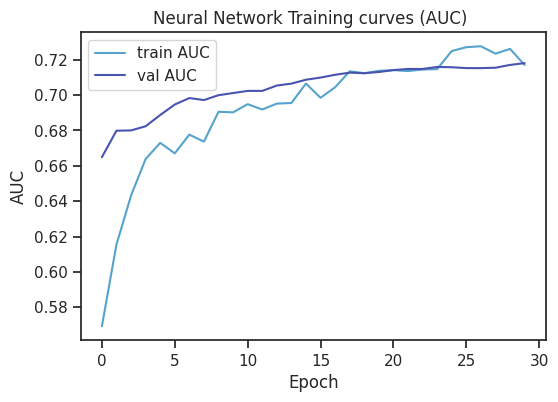

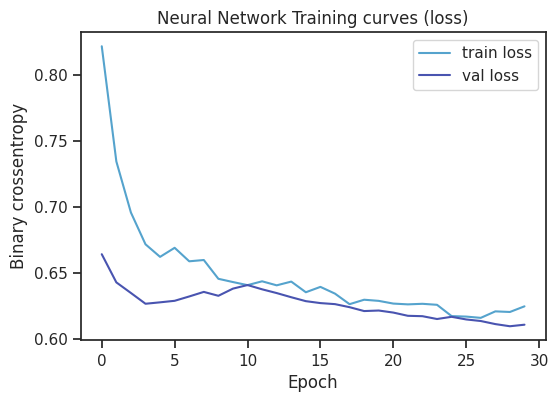

In [196]:
h = history.history
plt.figure(figsize=(6,4))
plt.plot(h['auc'], label='train AUC')
plt.plot(h['val_auc'], label='val AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.grid(False)
plt.title('Neural Network Training curves (AUC) ')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(h['loss'], label='train loss')
plt.plot(h['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.grid(False)
plt.ylabel('Binary crossentropy')
plt.title('Neural Network Training curves (loss)')
plt.legend()
plt.show()


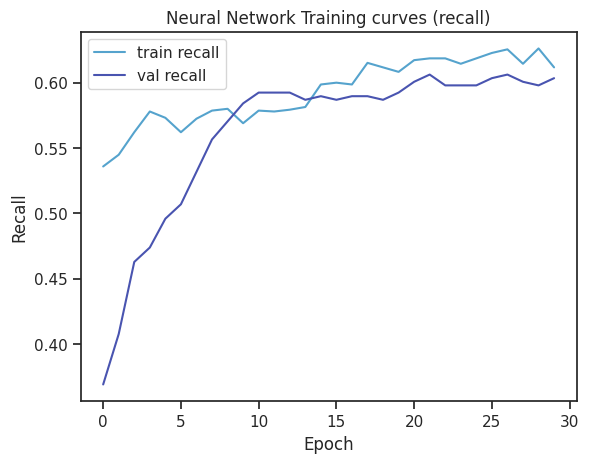

In [197]:
plt.plot(h['recall'], label='train recall')
plt.plot(h['val_recall'], label='val recall')
plt.title("Neural Network Training curves (recall)")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

In [198]:
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score, roc_auc_score, confusion_matrix

proba_val_nn = mlp.predict(X_val, batch_size=4096).ravel()
pred_val_nn_05 = (proba_val_nn >= 0.5).astype(int)


metrics_nn = {
    "Accuracy": accuracy_score(y_val, pred_val_nn_05, sample_weight=w_val),
    "F1": f1_score(y_val, pred_val_nn_05, sample_weight=w_val),
    "ROC_AUC": roc_auc_score(y_val, proba_val_nn, sample_weight=w_val),
    "ConfusionMatrix": confusion_matrix(y_val, pred_val_nn_05, sample_weight=w_val)#
}
metrics_nn

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step


{'Accuracy': 0.6639648230557321,
 'F1': 0.6422118770291875,
 'ROC_AUC': np.float64(0.7178376246190595),
 'ConfusionMatrix': array([[759.07491913, 288.50895333],
        [415.3785124 , 631.7214876 ]])}

/tmp/ipython-input-525053227.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)


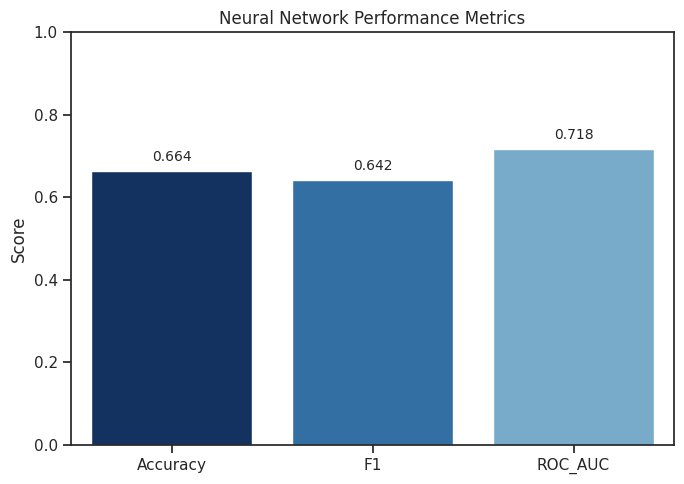

In [199]:
scalar_metrics = {k: v for k, v in metrics_nn.items() if k != "ConfusionMatrix"}
metrics_names = list(scalar_metrics.keys())
metrics_values = list(scalar_metrics.values())

palette = ["#08306b", "#2171b5", "#6baed6"]

plt.figure(figsize=(7,5))
bars = sns.barplot(x=metrics_names, y=metrics_values, palette=palette)

for bar, value in zip(bars.patches, metrics_values):
    height = bar.get_height()
    bars.annotate(f"{value:.3f}",
                  xy=(bar.get_x() + bar.get_width() / 2, height),
                  xytext=(0, 5),
                  textcoords="offset points",
                  ha='center', va='bottom', fontsize=10)

plt.ylim(0,1)
plt.ylabel("Score")
plt.title("Neural Network Performance Metrics")
plt.tight_layout()
plt.show()


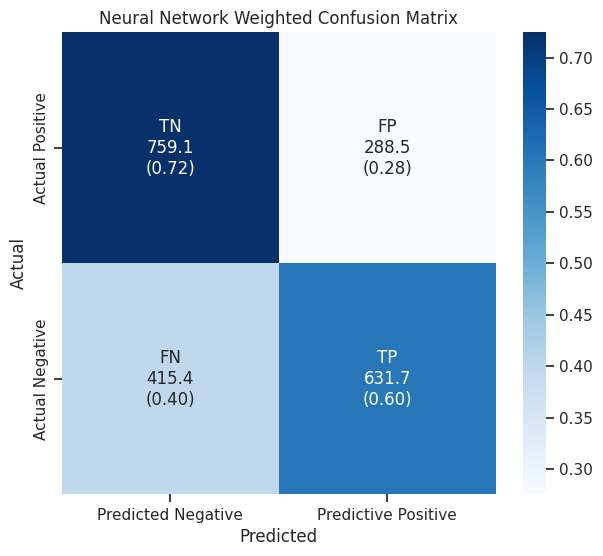

In [200]:
cm = metrics_nn["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Blues",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Weighted Confusion Matrix")
plt.show()

0.48346978


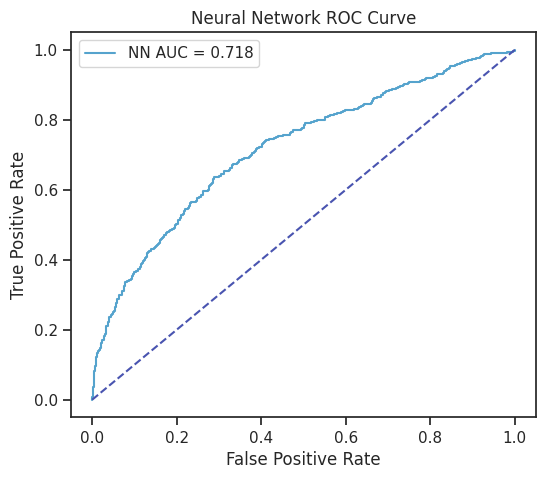

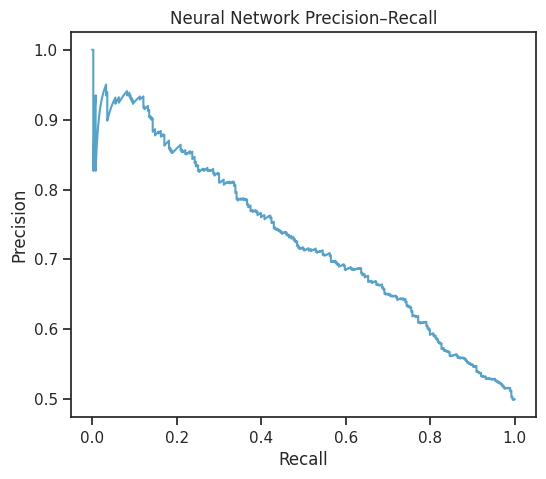

Weighted confusion matrix (threshold=0.5):
 [[759.07491913 288.50895333]
 [415.3785124  631.7214876 ]]


In [201]:
# ROC
fpr, tpr, thresholds = roc_curve(y_val, proba_val_nn, sample_weight=w_val)
J = tpr - fpr
best_thresh = thresholds[np.argmax(J)]

print(best_thresh)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"NN AUC = {roc_auc_score(y_val, proba_val_nn, sample_weight=w_val):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Neural Network ROC Curve");
plt.legend();
plt.show()

# PR
prec, rec, thr = precision_recall_curve(y_val, proba_val_nn, sample_weight=w_val)
plt.figure(figsize=(6,5))
plt.plot(rec, prec)
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.title("Neural Network Precision–Recall");
plt.show()

print("Weighted confusion matrix (threshold=0.5):\n", metrics_nn["ConfusionMatrix"])


66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
66/66 ━━━━━━━━━━━━━━━━━━━

/tmp/ipython-input-2542252773.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='Feature', y='Importance', palette='crest')


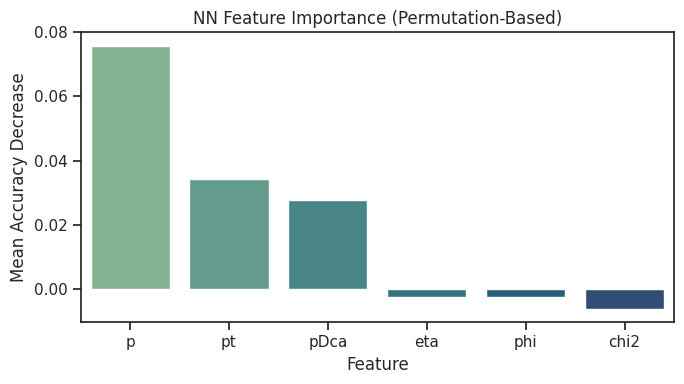

In [202]:
import numpy as np
from sklearn.inspection import permutation_importance
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class MLPClassifierWrapper:
    def __init__(self, model):
        self.model = model

    def fit(self, X, y):
        # Dummy fit (model already trained)
        return self

    def predict(self, X):
        proba = self.model.predict(X)
        proba = proba.ravel()
        return (proba > 0.5).astype(int)


mlp_wrapped = MLPClassifierWrapper(mlp)

result = permutation_importance(mlp_wrapped, X_val, y_val, scoring='accuracy')

importance_df = pd.DataFrame({
    'Feature': ['eta', 'pt', 'p', 'phi', 'pDca', 'chi2'],
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=False)

print(importance_df)

plt.figure(figsize=(7,4))
sns.barplot(data=importance_df, x='Feature', y='Importance', palette='crest')
plt.title('NN Feature Importance (Permutation-Based)')
plt.ylabel('Mean Accuracy Decrease')
plt.tight_layout()
plt.show()



In [203]:
from sklearn.metrics import roc_curve, precision_recall_curve, accuracy_score, f1_score, roc_auc_score, confusion_matrix

proba_val_nnTest = mlp.predict(X_test, batch_size=4096).ravel()
pred_val_nn_05Test = (proba_val_nnTest >= 0.5).astype(int)


metrics_nnTest = {
    "Accuracy": accuracy_score(y_test, pred_val_nn_05Test),
    "F1": f1_score(y_test, pred_val_nn_05Test),
    "ROC_AUC": roc_auc_score(y_test, proba_val_nnTest),
    "ConfusionMatrix": confusion_matrix(y_test, pred_val_nn_05Test)#
}
metrics_nnTest


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


{'Accuracy': 0.7215097105166728,
 'F1': 0.42249240121580545,
 'ROC_AUC': np.float64(0.731103751453861),
 'ConfusionMatrix': array([[1691,  594],
        [ 166,  278]])}

/tmp/ipython-input-3231397672.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)


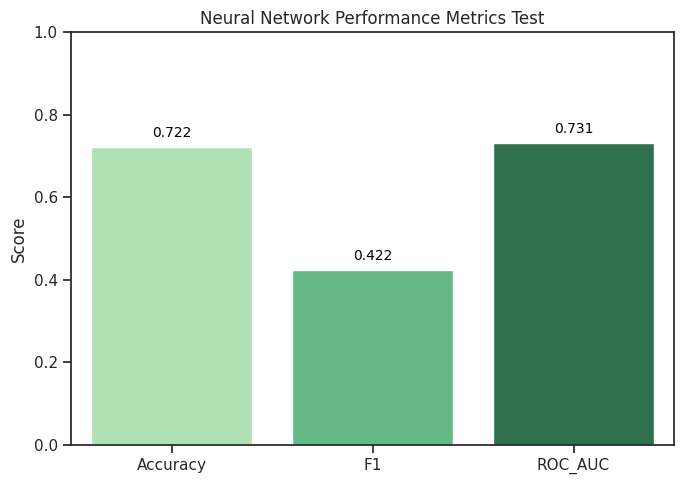

In [204]:
scalar_metricsTest = {k: v for k, v in metrics_nnTest.items() if k != "ConfusionMatrix"}
metrics_namesTest = list(scalar_metricsTest.keys())
metrics_valuesTest = list(scalar_metricsTest.values())

green_palette = ["#A7E9AF", "#57C785", "#247B4D"]

plt.figure(figsize=(7,5))
barsTest = sns.barplot(x=metrics_namesTest, y=metrics_valuesTest, palette=green_palette)

for bar, value in zip(barsTest.patches, metrics_valuesTest):
    height = bar.get_height()
    barsTest.annotate(f"{value:.3f}",      # <-- fixed name
                      xy=(bar.get_x() + bar.get_width() / 2, height),
                      xytext=(0, 5),
                      textcoords="offset points",
                      ha='center', va='bottom', fontsize=10, color='black')

plt.ylim(0, 1)
plt.ylabel("Score")
plt.title("Neural Network Performance Metrics Test")
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Neural Network Unweighted Confusion Matrix Test')

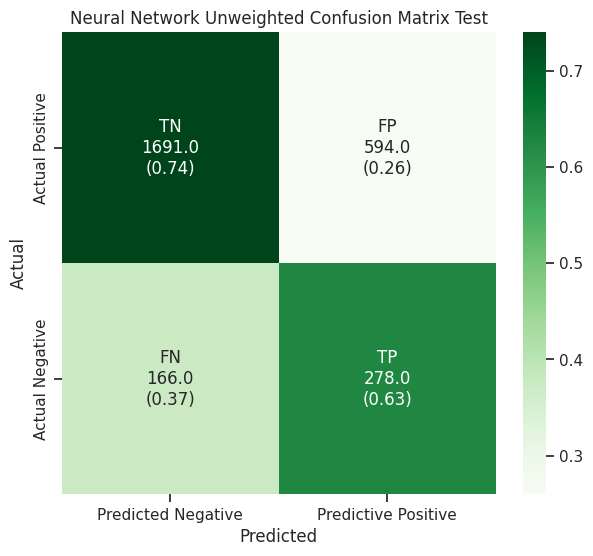

In [205]:
cm = metrics_nnTest["ConfusionMatrix"]

cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]

labels = np.array([["TN","FP"],
                   ["FN","TP"]])

annot = np.empty_like(cm).astype(str)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"


plt.figure(figsize=(7,6))
sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Greens",
            xticklabels=['Predicted Negative','Predictive Positive'], yticklabels=['Actual Positive','Actual Negative'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Neural Network Unweighted Confusion Matrix Test")


0.55015916


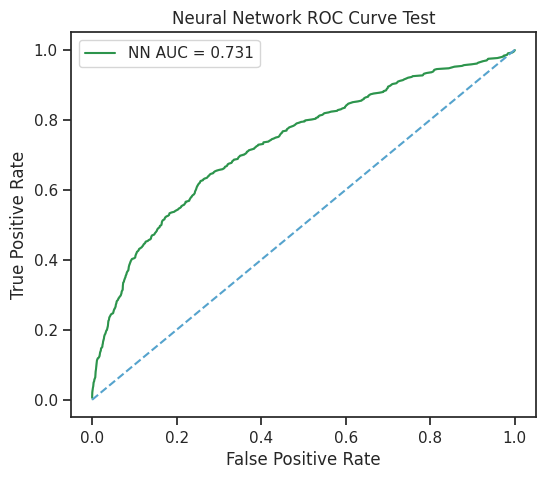

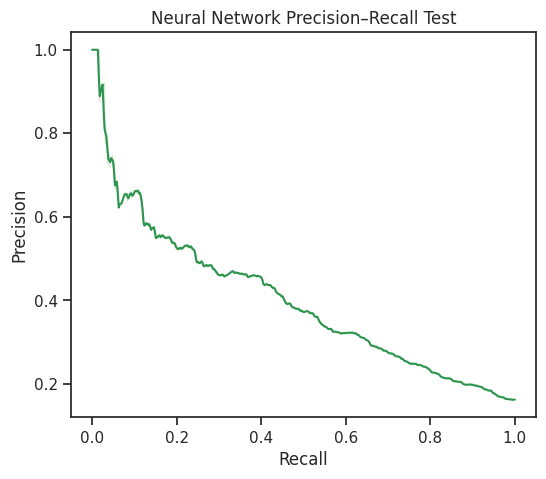

Weighted confusion matrix (threshold=0.5):
 [[759.07491913 288.50895333]
 [415.3785124  631.7214876 ]]


In [206]:
# ROC
fprTest, tprTest, thresholds = roc_curve(y_test, proba_val_nnTest)
J = tpr - fpr
best_thresh = thresholds[np.argmax(J)]

print(best_thresh)
plt.figure(figsize=(6,5))
sns.lineplot(x=fprTest, y=tprTest,color = sns.color_palette("Greens")[4],  label=f"NN AUC = {roc_auc_score(y_test, proba_val_nnTest):.3f}")
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate");
plt.ylabel("True Positive Rate")
plt.title("Neural Network ROC Curve Test");
plt.legend();
plt.show()

# PR
precTest, recTest, thr = precision_recall_curve(y_test, proba_val_nnTest)
plt.figure(figsize=(6,5))
sns.lineplot(x=recTest, y=precTest,color = sns.color_palette("Greens")[4])
plt.xlabel("Recall");
plt.ylabel("Precision")
plt.title("Neural Network Precision–Recall Test");
plt.show()

print("Weighted confusion matrix (threshold=0.5):\n", metrics_nn["ConfusionMatrix"])

66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


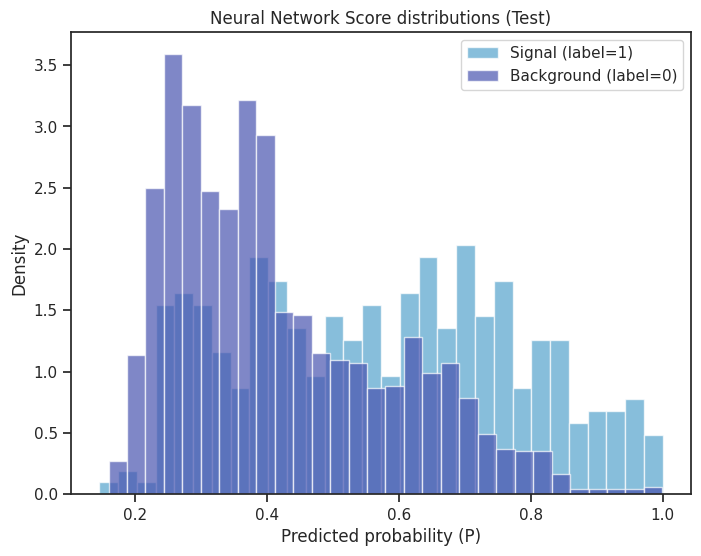

In [207]:
import numpy as np
import matplotlib.pyplot as plt


y_pred_prob = mlp.predict(X_val)

signal_scores = y_pred_prob[y_val == 1]
background_scores = y_pred_prob[y_val == 0]

plt.figure(figsize=(8,6))
plt.hist(signal_scores, bins=30, density=True, alpha=0.7, label='Signal (label=1)')
plt.hist(background_scores, bins=30, density=True, alpha=0.7, label='Background (label=0)')

plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Neural Network Score distributions (Test)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.show()


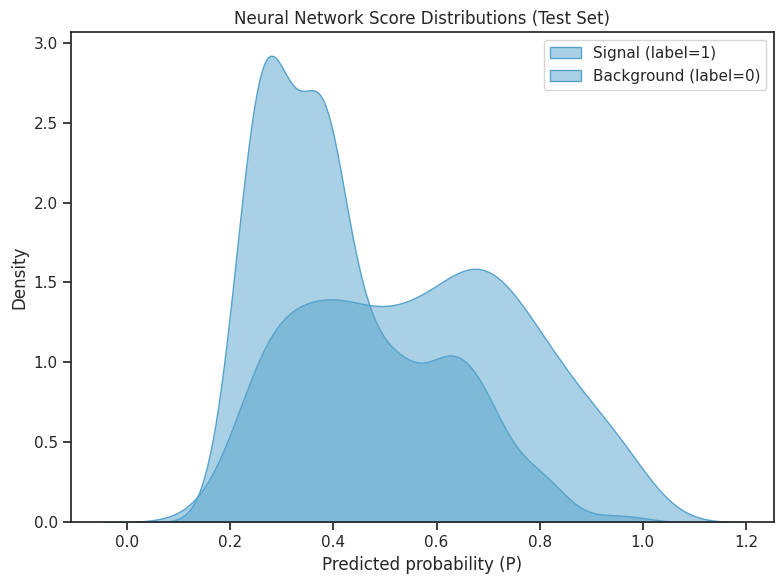

In [208]:
# Smooth KDE plot
plt.figure(figsize=(8,6))
sns.kdeplot(signal_scores, label='Signal (label=1)', fill=True, alpha=0.5)
sns.kdeplot(background_scores, label='Background (label=0)', fill=True, alpha=0.5)
plt.xlabel('Predicted probability (P)')
plt.ylabel('Density')
plt.title('Neural Network Score Distributions (Test Set)')
plt.legend()
plt.grid(False)#, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

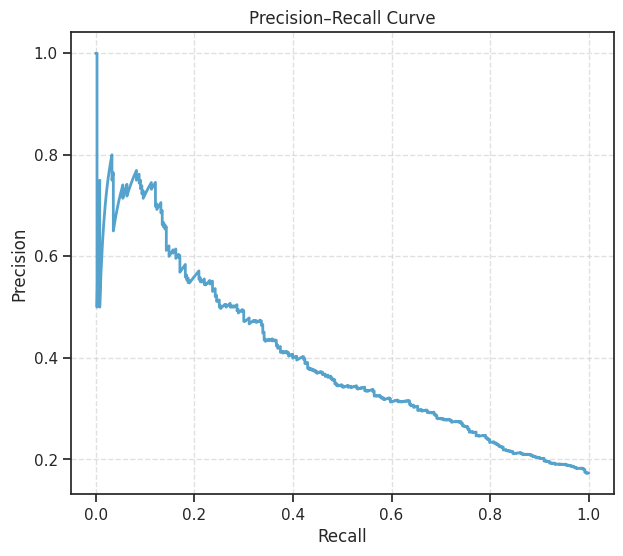

In [209]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

plt.figure(figsize=(7,6))
plt.plot(recall, precision, linewidth=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [210]:
# import xgboost as xgb
# from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



# xgbClassifier = xgb.XGBClassifier(random_state = 42)
# xgbClassifier.fit(X_train, y_train, sample_weight=w_train)


# y_pred = xgbClassifier.predict(X_val)

# accuracy = accuracy_score(y_val, y_pred)
# print(" Validation Accuracy:", accuracy)

# print("Confusion Matrix:")
# print(confusion_matrix(y_val, y_pred))

# print("Classification Report:")
# print(classification_report(y_val, y_pred))


 Validation Accuracy: 0.7513126491646778
Confusion Matrix:
[[1441  291]
 [ 230  133]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.83      0.85      1732
           1       0.31      0.37      0.34       363

    accuracy                           0.75      2095
   macro avg       0.59      0.60      0.59      2095
weighted avg       0.77      0.75      0.76      2095



In [211]:
# from sklearn.model_selection import RandomizedSearchCV
# param_grid = {
#     'n_estimators': [100, 200, 300, 500],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.01, 0.1, 0.2],
#     'min_child_weight': [1, 3, 5],
#     'sub_sample': [0.7, 0.85, 1.0],
#     'colsample_bytree': [0.7, 0.85, 1.0],
#     'reg_alpha': [0, 0.01, 0.1,1,10,100],
#     'reg_lambda': [0.5, 0.7, 1.3]
# }



# xgb_model = xgb.XGBClassifier(random_state=42)


# grid_search = RandomizedSearchCV(xgb_model, param_grid, cv=10, scoring= 'accuracy',n_iter = 10, n_jobs = 1, verbose = 2)

# grid_search.fit(X_train, y_train)

# best_xgb = grid_search.best_estimator_

# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)



Fitting 10 folds for each of 10 candidates, totalling 100 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:14] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:15] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:16] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=3, n_estimators=500, reg_alpha=1, reg_lambda=0.5, sub_sample=0.7; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:18] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:20] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0.1, reg_lambda=0.5, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:21] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:22] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:23] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   1.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:24] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.9s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:25] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:26] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, min_child_weight=1, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:27] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:28] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.85, learning_rate=0.01, max_depth=6, min_child_weight=5, n_estimators=100, reg_alpha=1, reg_lambda=0.5, sub_sample=0.85; total time=   0.2s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:30] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=9, min_child_weight=5, n_estimators=200, reg_alpha=100, reg_lambda=0.5, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.2, max_depth=3, min_child_weight=3, n_estimators=200, reg_alpha=0.01, reg_lambda=1.3, sub_sample=0.85; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:32] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s
[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=10, reg_lambda=1.3, sub_sample=1.0; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:33] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:34] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.8s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:35] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   2.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   1.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:40] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.5s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=100, reg_alpha=0.1, reg_lambda=0.7, sub_sample=0.7; total time=   0.6s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:43] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.3s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:44] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, min_child_weight=5, n_estimators=500, reg_alpha=0, reg_lambda=1.3, sub_sample=1.0; total time=   0.4s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.1s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:46] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, min_child_weight=5, n_estimators=200, reg_alpha=10, reg_lambda=0.7, sub_sample=0.7; total time=   0.2s
Best Parameters: {'sub_sample': 1.0, 'reg_lambda': 1.3, 'reg_alpha': 10, 'n_estimators': 100, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best Score: 0.8375143640060108


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [23:40:47] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "sub_sample" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [212]:
# y_predTest = best_xgb.predict(X_test)

# test_accuracy = accuracy_score(y_test, y_predTest)
# print("Test Accuracy:", test_accuracy)

# print("Confusion Matrix:")
# print(confusion_matrix(y_test, y_predTest))

# print("Classification Report:")
# print(classification_report(y_test, y_predTest))



Test Accuracy: 0.8435324294613411
Confusion Matrix:
[[2227   58]
 [ 369   75]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2285
           1       0.56      0.17      0.26       444

    accuracy                           0.84      2729
   macro avg       0.71      0.57      0.59      2729
weighted avg       0.81      0.84      0.81      2729



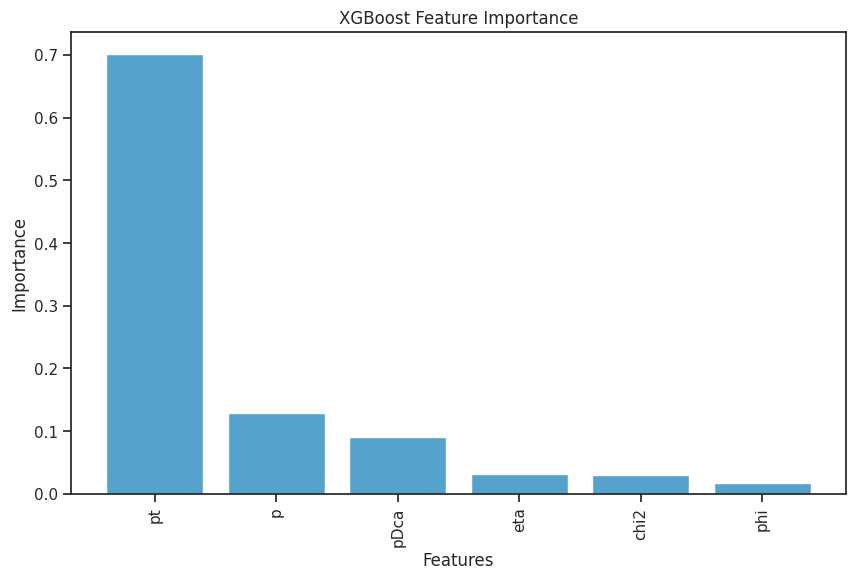

In [213]:
# feature_importances = best_xgb.feature_importances_
# feature_names = X_train_raw.columns

# sorted_indices = np.argsort(feature_importances)[::-1]

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(feature_importances)), feature_importances[sorted_indices], align='center')
# plt.xticks(range(len(feature_importances)), feature_names[sorted_indices], rotation=90)
# plt.xlabel('Features')
# plt.ylabel('Importance')
# plt.title('XGBoost Feature Importance')
# plt.show()

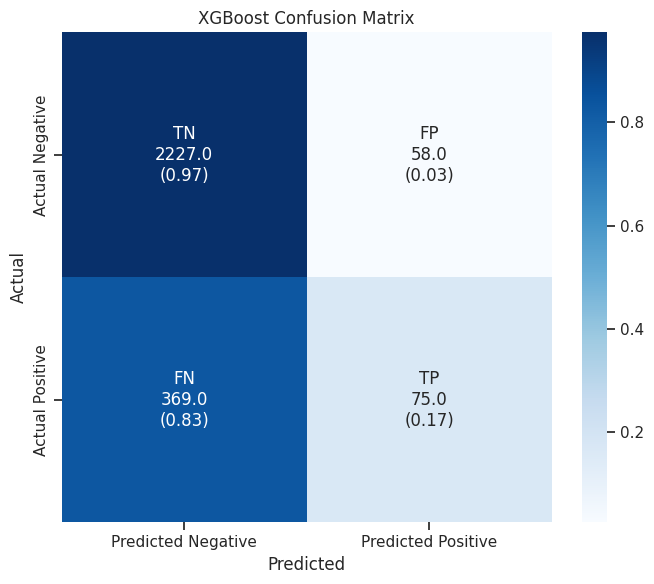

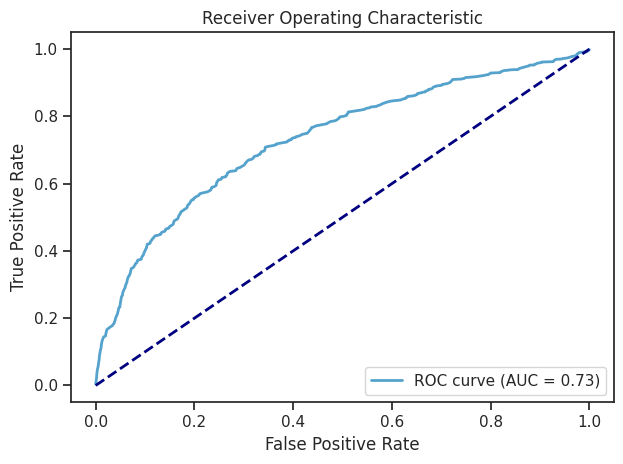

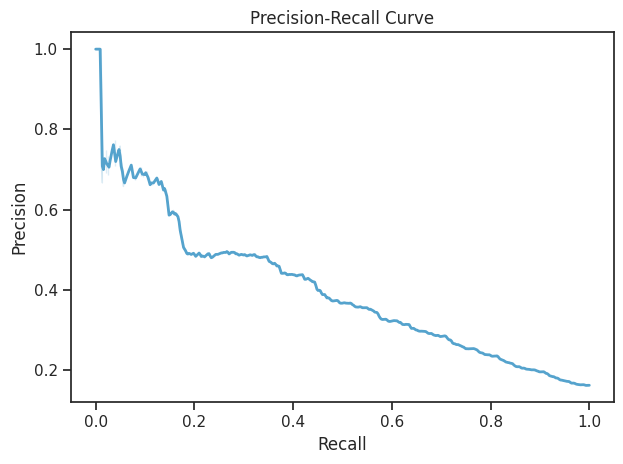

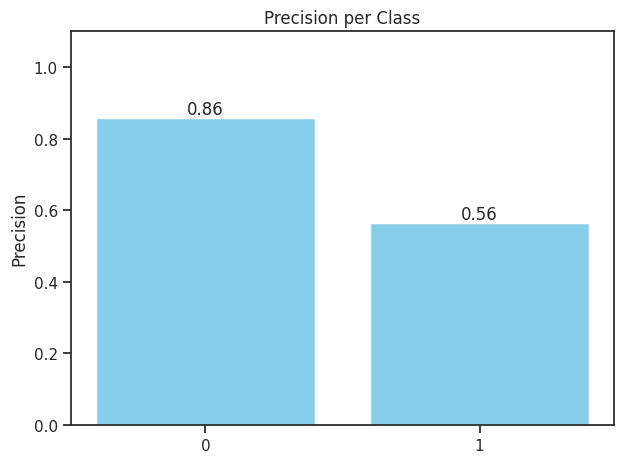

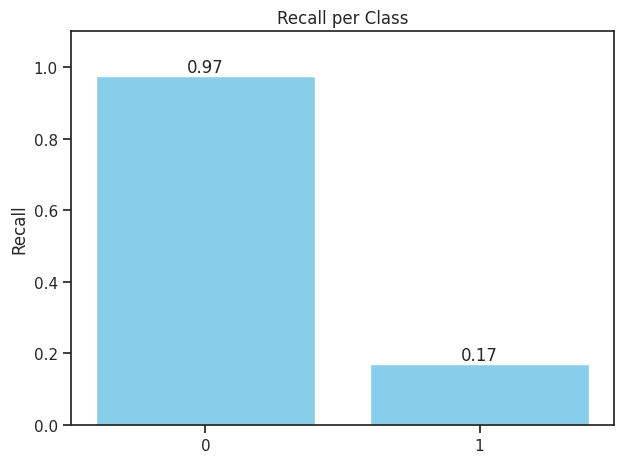

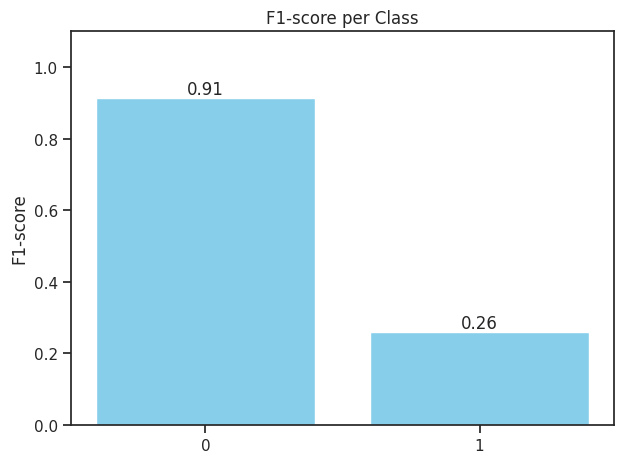

In [214]:
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from sklearn.metrics import (
#     confusion_matrix, roc_curve, auc,
#     precision_recall_curve, classification_report, accuracy_score
# )

# # Predict on test set
# y_predTest = best_xgb.predict(X_test)
# y_proba = best_xgb.predict_proba(X_test)[:, 1]

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_predTest)
# cm_frac = cm / cm.sum(axis=1)[:, np.newaxis]
# labels = np.array([["TN", "FP"], ["FN", "TP"]])
# annot = np.empty_like(cm).astype(str)
# for i in range(cm.shape[0]):
#     for j in range(cm.shape[1]):
#         annot[i, j] = f"{labels[i,j]}\n{cm[i,j]:.1f}\n({cm_frac[i,j]:.2f})"

# plt.figure(figsize=(7,6))
# sns.heatmap(cm_frac, annot=annot, fmt="", cmap="Blues",
#             xticklabels=['Predicted Negative','Predicted Positive'],
#             yticklabels=['Actual Negative','Actual Positive'])
# plt.xlabel("Predicted")
# plt.ylabel("Actual")
# plt.title("XGBoost Confusion Matrix")
# plt.tight_layout()
# plt.show()

# # ROC Curve
# fpr, tpr, _ = roc_curve(y_test, y_proba)
# roc_auc = auc(fpr, tpr)

# plt.figure()
# sns.lineplot(x=fpr, y=tpr,  lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
# plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.tight_layout()
# plt.show()

# # Precision-Recall Curve
# precision, recall, _ = precision_recall_curve(y_test, y_proba)

# plt.figure()
# sns.lineplot(x=recall,y= precision,  lw=2)
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.tight_layout()
# plt.show()

# report = classification_report(y_test, y_predTest, output_dict=True)
# metrics = ['precision', 'recall', 'f1-score']
# classes = [key for key in report.keys() if key.isdigit()]

# for metric in metrics:
#     values = [report[cls][metric] for cls in classes]
#     plt.figure()
#     bars = plt.bar(classes, values, color='skyblue')
#     plt.ylim(0, 1.1)
#     plt.title(f'{metric.capitalize()} per Class')
#     plt.ylabel(metric.capitalize())

#     # Add value labels above each bar
#     for bar in bars:
#         height = bar.get_height()
#         plt.text(bar.get_x() + bar.get_width()/2.0, height, f'{height:.2f}', ha='center', va='bottom')

#     plt.tight_layout()
#     plt.show()


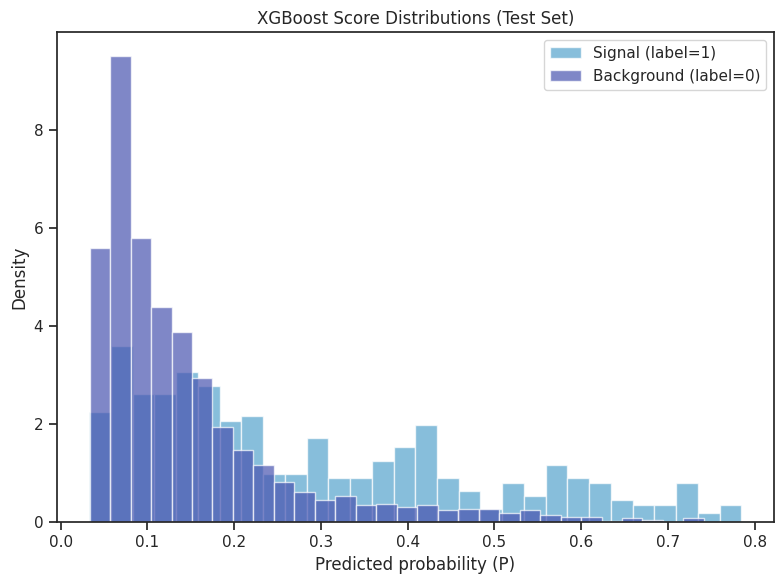

In [215]:
# # Get predicted probabilities for the positive (signal) class
# y_pred_prob_xgb = best_xgb.predict_proba(X_test)[:, 1]

# # Separate probabilities for signal (1) and background (0)
# signal_scores_xgb = y_pred_prob_xgb[y_test == 1]
# background_scores_xgb = y_pred_prob_xgb[y_test == 0]

# # Plot histograms
# plt.figure(figsize=(8,6))
# plt.hist(signal_scores_xgb, bins=30, density=True, alpha=0.7, label='Signal (label=1)')
# plt.hist(background_scores_xgb, bins=30, density=True, alpha=0.7, label='Background (label=0)')

# plt.xlabel('Predicted probability (P)')
# plt.ylabel('Density')
# plt.title('XGBoost Score Distributions (Test Set)')
# plt.legend()
# plt.grid(False)#, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


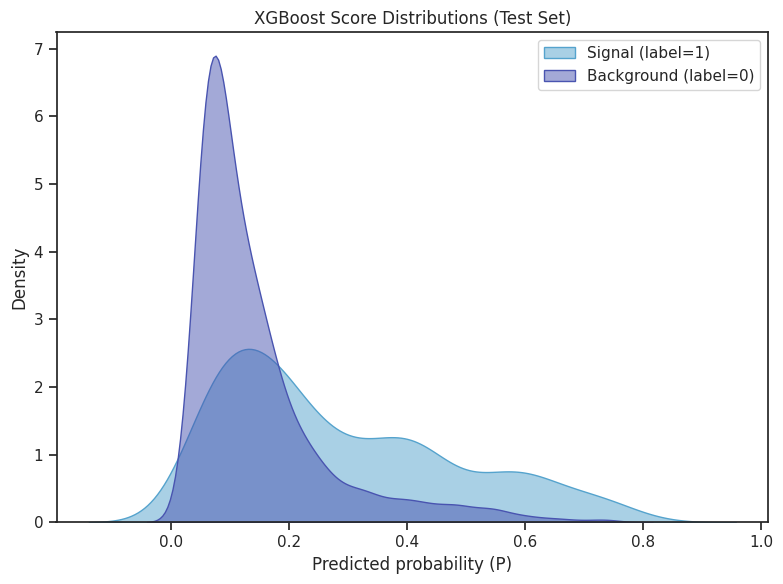

In [216]:
# plt.figure(figsize=(8,6))
# sns.kdeplot(signal_scores_xgb, label='Signal (label=1)', fill=True, alpha=0.5)
# sns.kdeplot(background_scores_xgb, label='Background (label=0)', fill=True, alpha=0.5)
# plt.xlabel('Predicted probability (P)')
# plt.ylabel('Density')
# plt.title('XGBoost Score Distributions (Test Set)')
# plt.legend()
# plt.grid(False)#, linestyle='--', alpha=0.6)
# plt.tight_layout()
# plt.show()


In [217]:
# #we can add code so that when we choose B mesons as signal we remove D from background and vice versa...

# # Define signal and D mesons
# signalPDG = [511, 521, 531, 541]   # B mesons
# dMesons   = [411, 421, 431]        # D mesons

# signal = []
# background = []

# for val in df1_filtered['motherPDG']:
#     if val in signalPDG:
#         signal.append(val)
#     elif val not in dMesons:  # keep only non-D backgrounds
#         background.append(val)

# print(len(signal))
# print(len(background))

# signalRows = []
# backgroundRows = []

# for _, row in df1_filtered.iterrows():
#     if row['motherPDG'] in signalPDG:
#         signalRows.append(row)
#     elif row['motherPDG'] not in dMesons:
#         backgroundRows.append(row)

# dfSignal = pd.DataFrame(signalRows)
# dfBackground = pd.DataFrame(backgroundRows)

# ratioSB = len(signal)/len(background) if len(background) > 0 else float('inf')

# print(ratioSB*100)
# dfSignal